In [1]:
import torch
import torchvision
from torch import nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn import init

from settings import EPOCHS
from unet import UNET
from Discriminator import Discriminator
import torchvision.transforms as transforms
from torch.nn import BCELoss, L1Loss, MSELoss
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from torch.optim import lr_scheduler


def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def get_scheduler(optimizer):
    
    def lambda_rule(epoch):
        lr_l = 1.0 - max(0, epoch + 1 - EPOCHS) / float(EPOCHS + 1)
        return lr_l
    
    return lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

def trainPix2Pix(model, data, totalEpochs=EPOCHS, genLr=0.0001, descLr=0.00005):
    genOptimizer = Adam( list(model.gen.parameters()), lr=0.0001)
    discOptimizer = Adam( list(model.disc.parameters()), lr=0.00005)
    
    net_g_scheduler = get_scheduler(genOptimizer)
    net_d_scheduler = get_scheduler(discOptimizer)

    
    criterion = MSELoss().cuda()
    criterionL1 = L1Loss().cuda()

    model.gen.train()
    model.disc.train()
    for epoch in range(totalEpochs):
        print("Epoch " + str(epoch))
        for minibatch, (color_and_gray, gray_three_channel) in enumerate(data):
            train_step(model, color_and_gray.cuda(), gray_three_channel.cuda(), criterion, genOptimizer, discOptimizer, criterionL1)
        
        update_learning_rate(net_g_scheduler, genOptimizer)
        update_learning_rate(net_d_scheduler, discOptimizer)

# assumes minibatch is only colord images.
def train_step(model, color, black_white, criterion, gen_optimizer, disc_optimizer, criterion_l1):    
    # generate images
    generated = model.generate(black_white)
    
    disc_optimizer.zero_grad()
    
    input_output = torch.cat((black_white, generated), 1)
    input_target = torch.cat((black_white, color), 1)
    
    # train with generated   
    pred_generated = model.discriminate(input_output.data)
    generated_labels = torch.tensor(0).expand_as(pred_generated).cuda()
    loss_false = criterion(pred_generated, generated_labels.float())
    
    # train with target
    pred_targets = model.discriminate(input_target)
    targets_labels = torch.tensor(1).expand_as(pred_targets).cuda()
    loss_true = criterion(pred_targets, targets_labels.float())
    
    print("Loss false: {} Loss true {}: ".format(loss_false, loss_true))
    loss_discriminator = (loss_false + loss_true) / 2
    loss_discriminator.backward()
    disc_optimizer.step()

    
    gen_optimizer.zero_grad()
    pred_output =  model.discriminate(input_output) 

    loss_gen = criterion(pred_output, targets_labels.float())
    # G(A) = B
    loss_ab = criterion_l1(black_white, color) * 0.9 # weight, L1 term 

    loss_gen = loss_gen + loss_ab
    
    loss_gen.backward()
    gen_optimizer.step()




class pix2pix(nn.Module):

    def __init__(self):
        super(pix2pix, self).__init__()
        numclasses = 3 #RGB
        numchannels = 64
        self.gen = UNET(numclasses, numchannels)
        self.disc = Discriminator()
#         self.criterion = CrossEntropyLoss()
        self.writer = SummaryWriter('runs/pix2pix')

    def log_image(self, images):
        # write to tensorboard
        img_grid = torchvision.utils.make_grid(images)
        self.writer.add_image('four_fashion_mnist_images', img_grid)

    def log_metrics(self, epoch, loss):
        self.writer.add_scalar('training loss', loss, epoch)
        self.trainData.append(loss)

    def generate(self, greyscale):
        return self.gen(greyscale)
        #Need to add dropout

    def discriminate(self, img):
        #(images, features, height, width)
        # Return average - 1 value for all images
        ret = self.disc(img)
        ret = torch.mean(ret, axis=2)
        ret = torch.mean(ret, axis=2)
        return ret






In [ ]:
model = pix2pix().cuda()

In [21]:
def TenToPic(image):
    s = image.size()
    ret = torch.zeros(s[1], s[2], s[0])
    for i in range(s[0]):
        ret[:, :, i] = image[i, :,:]
    return ret.detach().numpy().astype(float)


# In[11]:


from utils import get_datasets
train_dataset, test_dataset = get_datasets()
ex = None
for i in train_dataset:
    ex = i
    break

pix2pix(
  (gen): UNET(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, paddin

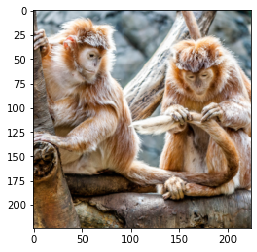

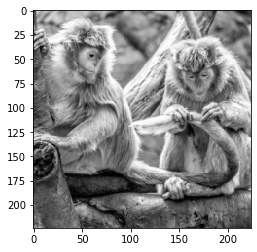

In [22]:
# out = model.generate(ex[1])
# plt.imshow(TenToPic(out[0,:,:,:]))
# plt.figure()
# plt.imshow(out.detach().numpy()[0,0,:,:])
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))
plt.figure()
plt.imshow(TenToPic(ex[1][0,:,:,:]))

model.cuda()

pix2pix(
  (gen): UNET(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, paddin

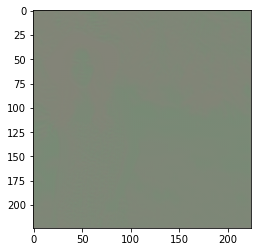

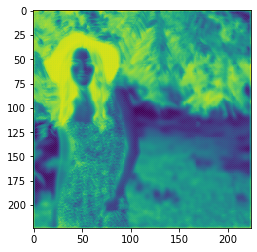

In [15]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.imshow(TenToPic(out[0,:,:,:]))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
model.cuda()

In [16]:
trainPix2Pix(model, train_dataset, totalEpochs=50)

Epoch 0
Loss false: 0.0053147259168326855 Loss true 0.8506990671157837: 
Loss false: 0.06725644320249557 Loss true 0.587623119354248: 
Loss false: 0.14868280291557312 Loss true 0.394340842962265: 
Loss false: 0.31649255752563477 Loss true 0.1526728868484497: 
Loss false: 0.32762160897254944 Loss true 0.15748736262321472: 
Loss false: 0.32664501667022705 Loss true 0.10707251727581024: 
Loss false: 0.3092021346092224 Loss true 0.13240300118923187: 
Loss false: 0.23224438726902008 Loss true 0.1489231437444687: 
Loss false: 0.1928578019142151 Loss true 0.03256126493215561: 
Loss false: 0.06825283169746399 Loss true 0.0820588767528534: 
Loss false: 0.06631583720445633 Loss true 0.1468096226453781: 
Loss false: 0.018560778349637985 Loss true 0.13343219459056854: 
Loss false: 0.02504298835992813 Loss true 0.07417287677526474: 
Loss false: 0.04433763027191162 Loss true 0.0293933916836977: 
Loss false: 0.025080733001232147 Loss true 0.053817857056856155: 
Loss false: 0.0020454348996281624 Loss 

Loss false: 0.01725813001394272 Loss true 2.0998436411900911e-07: 
Loss false: 0.002574222395196557 Loss true 1.5113848348846659e-05: 
Loss false: 0.0018192572752013803 Loss true 0.024533959105610847: 
Loss false: 0.022109434008598328 Loss true 0.005630542989820242: 
Loss false: 0.000714556488674134 Loss true 0.0011996497632935643: 
Loss false: 0.008959989063441753 Loss true 0.001703588292002678: 
Loss false: 0.00878574326634407 Loss true 2.290536394866649e-05: 
Loss false: 0.00019509850244503468 Loss true 0.0002567129849921912: 
Loss false: 2.788787242025137e-06 Loss true 0.007190151140093803: 
Loss false: 0.0030784776899963617 Loss true 4.376352080726065e-05: 
Loss false: 0.0029651601798832417 Loss true 0.0001100513618439436: 
Loss false: 0.0010504411766305566 Loss true 0.000963837665040046: 
Loss false: 0.007761234883219004 Loss true 0.00026879904908128083: 
Loss false: 0.02223435789346695 Loss true 2.722907083807513e-05: 
Loss false: 0.00021716029732488096 Loss true 0.0196222495287

Loss false: 0.0016136833000928164 Loss true 3.968013118083036e-08: 
Loss false: 0.0037289068568497896 Loss true 0.005460555665194988: 
Loss false: 0.00023767056700307876 Loss true 0.0034907145891338587: 
Loss false: 0.004660115111619234 Loss true 2.2543251816387055e-06: 
Loss false: 0.005168179050087929 Loss true 0.0021120759192854166: 
Loss false: 0.0005059047834947705 Loss true 0.008597733452916145: 
Loss false: 0.0026372228749096394 Loss true 7.227397873066366e-05: 
Loss false: 0.0027748558204621077 Loss true 0.007909904234111309: 
Loss false: 0.0009142898488789797 Loss true 0.0006190347485244274: 
Loss false: 0.0007897948962636292 Loss true 0.006736658047884703: 
Loss false: 0.0027554116677492857 Loss true 7.542702951468527e-05: 
Loss false: 9.174728620564565e-05 Loss true 0.005453106015920639: 
Loss false: 0.00342771434225142 Loss true 0.002233681036159396: 
Loss false: 0.0003621141368057579 Loss true 0.0041474695317447186: 
Loss false: 0.00023166349274106324 Loss true 1.637174864

Loss false: 1.0937844763247995e-06 Loss true 0.006778069771826267: 
Loss false: 0.0001370390091324225 Loss true 0.0005497355596162379: 
Loss false: 0.0001830918772611767 Loss true 0.0007400790927931666: 
Loss false: 4.888256444246508e-05 Loss true 0.003229146357625723: 
Loss false: 8.555863132642116e-06 Loss true 0.0014714529970660806: 
Loss false: 5.135340757078666e-07 Loss true 0.0038931553717702627: 
Loss false: 0.0006140192854218185 Loss true 7.72015264374204e-05: 
Loss false: 2.5569981517037377e-05 Loss true 0.008044087328016758: 
Loss false: 0.0006214630557224154 Loss true 0.001897611073218286: 
Loss false: 2.2209807866602205e-05 Loss true 0.002470957348123193: 
Loss false: 0.012406140565872192 Loss true 0.0046401238068938255: 
Loss false: 0.007516738958656788 Loss true 3.413140439079143e-05: 
Loss false: 5.156522092875093e-05 Loss true 0.002894194796681404: 
Loss false: 0.00011748342512873933 Loss true 0.0014907537261024117: 
Loss false: 0.00047365552745759487 Loss true 3.745690

Loss false: 0.002158546820282936 Loss true 0.004408871755003929: 
Loss false: 0.00023599601991008967 Loss true 0.00130551983602345: 
Loss false: 0.0006676373304799199 Loss true 0.000393734488170594: 
Loss false: 0.00010462036152603105 Loss true 0.0016706745373085141: 
Loss false: 0.0010922198416665196 Loss true 0.00040608999552205205: 
Loss false: 0.000955833587795496 Loss true 0.0005041483673267066: 
Loss false: 4.857940075453371e-05 Loss true 0.0018936250125989318: 
Loss false: 3.5281336749903858e-06 Loss true 0.0001142373148468323: 
Loss false: 0.0007001875783316791 Loss true 0.000294903467874974: 
Loss false: 2.931998642452527e-05 Loss true 7.115544576663524e-05: 
Loss false: 0.006656870245933533 Loss true 0.0070628696121275425: 
Loss false: 0.0008022323600016534 Loss true 7.380828901659697e-05: 
Loss false: 0.001396103180013597 Loss true 0.0004734503454528749: 
Loss false: 0.0006184260710142553 Loss true 0.0014619478024542332: 
Loss false: 0.0008552239742130041 Loss true 0.0001719

Loss false: 0.0005865396815352142 Loss true 0.00034790014615282416: 
Loss false: 0.00014825287507846951 Loss true 2.8347580155241303e-05: 
Loss false: 4.6591234422521666e-05 Loss true 0.0003796790260821581: 
Loss false: 0.0003908209328074008 Loss true 1.9601107851485722e-05: 
Loss false: 0.00013414800923783332 Loss true 4.809423262486234e-05: 
Loss false: 0.0008128717308863997 Loss true 1.600101859366987e-05: 
Loss false: 5.488560054800473e-05 Loss true 2.29418928938685e-05: 
Loss false: 0.0005610496154986322 Loss true 0.0014557053800672293: 
Loss false: 0.0001143488843808882 Loss true 0.0014230700908228755: 
Loss false: 0.0007027568062767386 Loss true 7.689911581110209e-05: 
Loss false: 0.0009595275623723865 Loss true 0.0011548761976882815: 
Loss false: 0.0012260433286428452 Loss true 0.000345600419677794: 
Loss false: 0.00014091975754126906 Loss true 0.00017502254922874272: 
Loss false: 5.228440204518847e-05 Loss true 0.0014006426790729165: 
Loss false: 0.0001619243557797745 Loss tru

Loss false: 6.152414425741881e-05 Loss true 5.301564306137152e-05: 
Loss false: 4.6601755457231775e-05 Loss true 0.00011447697761468589: 
Loss false: 1.5846810129005462e-05 Loss true 4.171557179688534e-07: 
Loss false: 0.00015217711916193366 Loss true 0.00010844155622180551: 
Loss false: 0.0013416159199550748 Loss true 3.0265286113717593e-05: 
Loss false: 4.173476918367669e-05 Loss true 8.760207856539637e-05: 
Loss false: 0.0015477555571123958 Loss true 0.00044413094292394817: 
Loss false: 0.00015715896734036505 Loss true 0.001640234375372529: 
Loss false: 2.3068086107969066e-08 Loss true 0.0003763160784728825: 
Loss false: 0.00032754827407188714 Loss true 0.00014440284576267004: 
Loss false: 0.00034217938082292676 Loss true 0.00015582084597554058: 
Loss false: 0.0007954853354021907 Loss true 0.001510958536528051: 
Loss false: 5.485627752932487e-06 Loss true 1.64470802701544e-05: 
Loss false: 1.0954778190352954e-05 Loss true 0.00019577972125262022: 
Loss false: 8.757085083743732e-07 Lo

Loss false: 2.2169206204125658e-05 Loss true 0.0005166417104192078: 
Loss false: 7.323525642277673e-05 Loss true 0.00015271009760908782: 
Loss false: 0.00012023130693705752 Loss true 1.4154488781059626e-07: 
Loss false: 0.00011184810136910528 Loss true 8.971538591140416e-06: 
Loss false: 6.1150269175414e-05 Loss true 0.0004640249244403094: 
Loss false: 0.002250762190669775 Loss true 2.740151103353128e-06: 
Loss false: 3.9133811924330075e-07 Loss true 0.00019599161169026047: 
Loss false: 0.00042079019476659596 Loss true 0.0002827624848578125: 
Loss false: 0.0011188923381268978 Loss true 5.976191005174769e-06: 
Loss false: 0.0011048581218346953 Loss true 0.0011207899078726768: 
Loss false: 1.3151987332093995e-05 Loss true 3.115179083579278e-07: 
Loss false: 0.0001227235043188557 Loss true 1.819336466724053e-05: 
Loss false: 0.0005229704547673464 Loss true 5.672744009643793e-05: 
Loss false: 0.000882109918165952 Loss true 0.000244420109083876: 
Loss false: 0.0006116668228060007 Loss true 

Loss false: 0.0005591948283836246 Loss true 0.0008860693778842688: 
Loss false: 7.237598964593417e-08 Loss true 5.0725149776553735e-05: 
Loss false: 0.00012556753063108772 Loss true 1.4210854715202004e-06: 
Loss false: 0.0010044871596619487 Loss true 3.029600748050143e-06: 
Loss false: 5.735880222346168e-06 Loss true 0.00089211919112131: 
Loss false: 0.00015538607840426266 Loss true 0.0005136870895512402: 
Loss false: 1.5725831872259732e-06 Loss true 5.242533006821759e-05: 
Loss false: 5.682383198291063e-05 Loss true 4.9267800932284445e-05: 
Loss false: 9.687383862910792e-05 Loss true 7.979117071954533e-05: 
Loss false: 5.891402543056756e-05 Loss true 0.00017706448852550238: 
Loss false: 8.349680138053373e-05 Loss true 5.1643673941725865e-05: 
Loss false: 0.00016333043458871543 Loss true 1.5367504602181725e-06: 
Loss false: 6.933165423106402e-05 Loss true 0.000696171831805259: 
Loss false: 9.434929233975708e-05 Loss true 0.0007253519725054502: 
Loss false: 0.0005842942628078163 Loss tr

Loss false: 0.0001729462092043832 Loss true 0.00020097280503250659: 
Loss false: 2.716221752052661e-05 Loss true 0.001282739918678999: 
Loss false: 0.002564613241702318 Loss true 7.628752427990548e-06: 
Loss false: 0.0002767792611848563 Loss true 0.0002991336223203689: 
Loss false: 0.0003579107578843832 Loss true 5.240893005975522e-05: 
Loss false: 0.006862241309136152 Loss true 0.003465847345069051: 
Loss false: 4.661959610530175e-05 Loss true 0.00020177803526166826: 
Loss false: 0.003986466210335493 Loss true 0.0005274110590107739: 
Loss false: 0.00023399402562063187 Loss true 0.0019141084048897028: 
Loss false: 0.000403638812713325 Loss true 0.0005927274469286203: 
Loss false: 1.2094133126083761e-06 Loss true 7.591591838718159e-06: 
Loss false: 8.113204239634797e-05 Loss true 9.474446414969862e-05: 
Loss false: 0.00040012068348005414 Loss true 0.00010639678657753393: 
Loss false: 0.0014505068538710475 Loss true 0.0015226814430207014: 
Loss false: 4.991167952539399e-05 Loss true 3.08

Loss false: 0.0004985721898265183 Loss true 1.1924968021048699e-05: 
Loss false: 1.2490943845477886e-05 Loss true 1.7101287085097283e-05: 
Loss false: 0.0009224599343724549 Loss true 0.00024190499971155077: 
Loss false: 6.734332419000566e-05 Loss true 0.0002753032313194126: 
Loss false: 0.0001228798064403236 Loss true 2.538888293202035e-05: 
Loss false: 0.00240052817389369 Loss true 0.0009754526545293629: 
Loss false: 8.845478305374854e-07 Loss true 8.489860192639753e-05: 
Loss false: 0.0013426457298919559 Loss true 0.0036435832735151052: 
Loss false: 0.0012711402960121632 Loss true 0.00011704985809046775: 
Loss false: 0.0014564460143446922 Loss true 1.2925393093610182e-06: 
Loss false: 1.3577449919921492e-07 Loss true 4.495603889154154e-07: 
Loss false: 0.0011869956506416202 Loss true 0.00013079539348836988: 
Loss false: 0.00046706676948815584 Loss true 0.0009640300995670259: 
Loss false: 3.372601713635959e-05 Loss true 2.8072552140656626e-06: 
Loss false: 0.0022939187474548817 Loss t

Loss false: 4.380136033432791e-06 Loss true 0.00014545909652952105: 
Loss false: 0.0002492074272595346 Loss true 0.00017217964341398329: 
Loss false: 0.00022125369287095964 Loss true 0.00018649666162673384: 
Loss false: 0.0012739775702357292 Loss true 0.0017618724377825856: 
Loss false: 0.00011293512216070667 Loss true 3.00237734336406e-05: 
Loss false: 3.182514410582371e-05 Loss true 8.825488475849852e-05: 
Loss false: 1.783115840225946e-05 Loss true 0.00046344989095814526: 
Loss false: 8.49583520903252e-05 Loss true 0.00013272478827275336: 
Loss false: 2.9657054255949333e-05 Loss true 6.443970050895587e-05: 
Loss false: 0.001957906177267432 Loss true 0.0009779338724911213: 
Loss false: 0.00025821273447945714 Loss true 0.0005594207323156297: 
Loss false: 6.639844650635496e-05 Loss true 0.00032985000871121883: 
Loss false: 0.0003913978871423751 Loss true 0.0002988285559695214: 
Loss false: 0.0006127297529019415 Loss true 0.00038364980719052255: 
Loss false: 9.865254833130166e-05 Loss t

Loss false: 0.0008675633580423892 Loss true 0.00018190831178799272: 
Loss false: 3.565104634617455e-05 Loss true 0.0004654589283745736: 
Loss false: 0.000337541860062629 Loss true 0.0001689631026238203: 
Loss false: 0.00041662639705464244 Loss true 1.9263739886810072e-05: 
Loss false: 0.0005515171214938164 Loss true 0.0009112555999308825: 
Loss false: 1.2273615084268386e-06 Loss true 0.00013528876297641546: 
Loss false: 0.0004934031167067587 Loss true 0.001110997749492526: 
Loss false: 0.0007323647732846439 Loss true 1.0493668924027588e-05: 
Loss false: 0.0004821904585696757 Loss true 2.3888445866759866e-05: 
Loss false: 5.252178380033001e-05 Loss true 0.0016134720062837005: 
Loss false: 0.0008694510324858129 Loss true 0.0028906301595270634: 
Loss false: 0.0006783684948459268 Loss true 0.0021565966308116913: 
Loss false: 0.0002443426928948611 Loss true 0.00024657929316163063: 
Loss false: 0.0018712938763201237 Loss true 0.0001220468693645671: 
Loss false: 0.006057963706552982 Loss true

Loss false: 0.0018262722296640277 Loss true 0.0005884513957425952: 
Loss false: 0.0014837301569059491 Loss true 0.00027430328191258013: 
Loss false: 0.0009005970787256956 Loss true 7.662234565941617e-05: 
Loss false: 0.0005102302529849112 Loss true 0.0010761109879240394: 
Loss false: 0.0010814195265993476 Loss true 0.0004057753540109843: 
Loss false: 1.4857909263810143e-05 Loss true 0.0002441871911287308: 
Loss false: 4.1606508602853864e-05 Loss true 2.323344597243704e-05: 
Loss false: 0.0008295130101032555 Loss true 0.00020532924099825323: 
Loss false: 8.40655411593616e-05 Loss true 0.00033319697831757367: 
Loss false: 0.0009034804534167051 Loss true 5.578260243055411e-06: 
Loss false: 0.0015768560115247965 Loss true 0.0012846277095377445: 
Loss false: 0.00201579462736845 Loss true 0.000928494380787015: 
Loss false: 0.004438570700585842 Loss true 0.003213023766875267: 
Loss false: 0.0001441571075702086 Loss true 0.0007133781327866018: 
Loss false: 0.002116537420079112 Loss true 0.0100

Loss false: 0.0003345946315675974 Loss true 0.0009866729378700256: 
Loss false: 0.0003208877460565418 Loss true 0.0006820959970355034: 
Loss false: 0.00010129081056220457 Loss true 5.998359483783133e-06: 
Loss false: 0.0012429875787347555 Loss true 0.0002340327191632241: 
Loss false: 0.00036073027877137065 Loss true 0.00025754066882655025: 
Loss false: 0.0012528226943686604 Loss true 0.002138438168913126: 
Loss false: 0.0015023683663457632 Loss true 0.0013567876303568482: 
Loss false: 0.00033574074041098356 Loss true 1.797285040083807e-05: 
Loss false: 0.00011240052845096216 Loss true 0.00023408014385495335: 
Loss false: 0.00041043342207558453 Loss true 0.0005191919044591486: 
Loss false: 3.600050331442617e-05 Loss true 0.00019195883942302316: 
Loss false: 1.102509713746258e-06 Loss true 0.0003082491166424006: 
Loss false: 2.6142173737753183e-05 Loss true 0.00023160626005847007: 
Loss false: 0.0001378765155095607 Loss true 2.2053643988328986e-05: 
Loss false: 0.0006813937798142433 Loss

Loss false: 0.00029593819635920227 Loss true 3.3120795706054196e-05: 
Loss false: 0.0002292685239808634 Loss true 0.00012332502228673548: 
Loss false: 0.0007709267665632069 Loss true 0.0004237815155647695: 
Loss false: 3.2358332191506634e-07 Loss true 5.2862989832647145e-05: 
Loss false: 0.0003317009541206062 Loss true 0.00019916861492674798: 
Loss false: 8.35971295600757e-05 Loss true 0.00023603941372130066: 
Loss false: 0.0023278340231627226 Loss true 0.0014471717877313495: 
Loss false: 0.0007570979651063681 Loss true 0.0009442308801226318: 
Loss false: 0.00016657043306622654 Loss true 0.00019829641678370535: 
Loss false: 0.0002849333977792412 Loss true 0.0010472285794094205: 
Loss false: 0.0005957438261248171 Loss true 0.0006775921210646629: 
Loss false: 0.0005213450640439987 Loss true 0.0002678227028809488: 
Loss false: 0.0005609826184809208 Loss true 9.561322804074734e-05: 
Loss false: 0.0002362147206440568 Loss true 0.00032945608836598694: 
Loss false: 0.002374402480199933 Loss t

Loss false: 0.000288693088805303 Loss true 0.0005414046463556588: 
Loss false: 0.00031942263012751937 Loss true 0.0013382683973759413: 
Loss false: 0.001395410974510014 Loss true 0.0017309954855591059: 
Loss false: 0.003267025575041771 Loss true 0.008799592964351177: 
Loss false: 0.004696042276918888 Loss true 0.0028383894823491573: 
Loss false: 0.002981095341965556 Loss true 0.0027680923230946064: 
Loss false: 0.001278952695429325 Loss true 0.0027246989775449038: 
Loss false: 0.0003097544249612838 Loss true 2.52473228101735e-06: 
Loss false: 0.003500543534755707 Loss true 0.0015708956634625793: 
Loss false: 0.004099036566913128 Loss true 0.003240346908569336: 
Loss false: 0.0015369747998192906 Loss true 0.00010006895900005475: 
Loss false: 2.0624038370442577e-05 Loss true 0.0002992057998199016: 
Loss false: 0.002391968620941043 Loss true 0.0017604816239327192: 
Loss false: 0.0005431205499917269 Loss true 0.0002217853325419128: 
Loss false: 0.0005513527430593967 Loss true 0.00068176601

Loss false: 6.0870606830576435e-06 Loss true 1.9766650439123623e-05: 
Loss false: 1.2227041224832647e-05 Loss true 1.819387216528412e-05: 
Loss false: 0.0004966252017766237 Loss true 0.00014098385872785002: 
Loss false: 0.001693650265224278 Loss true 0.002921308856457472: 
Loss false: 0.0002085404994431883 Loss true 9.304528794018552e-05: 
Loss false: 0.00011096616799477488 Loss true 0.001002768287435174: 
Loss false: 0.0008663810440339148 Loss true 0.0009862647857517004: 
Loss false: 0.0007477747858501971 Loss true 0.0015567390946671367: 
Loss false: 5.504845375980949e-06 Loss true 1.2825296380469808e-06: 
Loss false: 0.0007568947039544582 Loss true 0.00014150806237012148: 
Loss false: 0.00028484524227678776 Loss true 3.394362283870578e-05: 
Loss false: 0.00014515755174215883 Loss true 2.506018972781021e-05: 
Loss false: 0.0014763084473088384 Loss true 0.0018576099537312984: 
Loss false: 1.2748744666168932e-05 Loss true 0.00041175493970513344: 
Loss false: 2.1954108888166957e-05 Loss 

Loss false: 0.00010897046740865335 Loss true 2.1095784177305177e-05: 
Loss false: 0.0005303233047015965 Loss true 0.00046742591075599194: 
Loss false: 0.0002521973510738462 Loss true 0.0006077036960050464: 
Loss false: 0.0001145127898780629 Loss true 0.0001117158608394675: 
Loss false: 2.3339207473327406e-05 Loss true 0.00017383700469508767: 
Loss false: 0.0007879995973780751 Loss true 0.00024246341490652412: 
Loss false: 0.00023310555843636394 Loss true 3.589900734368712e-05: 
Loss false: 5.383711322792806e-05 Loss true 1.2967306247446686e-05: 
Loss false: 2.3343017119259457e-07 Loss true 0.0003667369019240141: 
Loss false: 4.083861313119996e-06 Loss true 0.00011873249604832381: 
Loss false: 3.770552439164021e-06 Loss true 0.0006008816417306662: 
Loss false: 3.95701608795207e-05 Loss true 0.00014976636157371104: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 11
Loss false: 2.997992851305753e-05 Loss true 1.4087294175624265e-07: 
Loss false: 4.519044068729272e-06 Loss true 

Loss false: 0.0005361789371818304 Loss true 0.00032057822681963444: 
Loss false: 8.723701466806233e-05 Loss true 8.793935558060184e-05: 
Loss false: 3.572631612769328e-05 Loss true 0.0003644461976364255: 
Loss false: 0.0010877071181312203 Loss true 0.0021515176631510258: 
Loss false: 0.0001582610420882702 Loss true 2.654012860148214e-06: 
Loss false: 0.0010661899577826262 Loss true 0.0007678683614358306: 
Loss false: 0.0011879060184583068 Loss true 0.00023031634918879718: 
Loss false: 0.0011233515106141567 Loss true 0.0006488675717264414: 
Loss false: 2.1781639588880353e-05 Loss true 0.00042092494550161064: 
Loss false: 5.707978743885178e-06 Loss true 2.9092300337651977e-06: 
Loss false: 0.00017045234562829137 Loss true 2.4596283765276894e-05: 
Loss false: 0.001867484301328659 Loss true 0.002493556123226881: 
Loss false: 0.0010264579905197024 Loss true 3.150542397634126e-05: 
Loss false: 7.69907419453375e-05 Loss true 9.455194958718494e-05: 
Loss false: 2.26202482735971e-05 Loss true 4

Loss false: 0.00046751677291467786 Loss true 0.0003152157587464899: 
Loss false: 0.0008983447914943099 Loss true 2.7010548365069553e-05: 
Loss false: 0.0011626618215814233 Loss true 0.0011361312353983521: 
Loss false: 3.7350244383560494e-05 Loss true 6.724667400703765e-07: 
Loss false: 0.0005506811430677772 Loss true 0.0013617363292723894: 
Loss false: 0.0001665184972807765 Loss true 0.0002481316914781928: 
Loss false: 0.00036532236845232546 Loss true 0.003089138539507985: 
Loss false: 5.937057358096354e-05 Loss true 0.0002153212553821504: 
Loss false: 0.000268953968770802 Loss true 0.0010405961656942964: 
Loss false: 0.00045615510316565633 Loss true 0.00046636982006020844: 
Loss false: 0.0002593809913378209 Loss true 7.895438102423213e-06: 
Loss false: 2.5805638870224357e-05 Loss true 9.473518002778292e-05: 
Loss false: 3.462205859250389e-05 Loss true 3.1173744901025202e-06: 
Loss false: 9.830583439907059e-05 Loss true 9.535359822621103e-06: 
Loss false: 0.000390650617191568 Loss true

Loss false: 0.000946563552133739 Loss true 0.0002700533077586442: 
Loss false: 0.0006853776285424829 Loss true 0.0008659548475407064: 
Loss false: 0.0015692943707108498 Loss true 0.0006101246690377593: 
Loss false: 0.00030555721605196595 Loss true 0.00022444916248787194: 
Loss false: 0.00046032905811443925 Loss true 0.0008627060451544821: 
Loss false: 0.002154623158276081 Loss true 0.006367204245179892: 
Loss false: 0.0002846814750228077 Loss true 0.0009076605783775449: 
Loss false: 0.0002877831575460732 Loss true 0.0009922563331201673: 
Loss false: 0.0005625043413601816 Loss true 0.00046092038974165916: 
Loss false: 4.642988642444834e-05 Loss true 2.1075529730296694e-05: 
Loss false: 0.00015725934645161033 Loss true 0.00013939174823462963: 
Loss false: 1.1909711247426458e-05 Loss true 3.850008312156206e-09: 
Loss false: 9.737649816088378e-05 Loss true 0.0015606736997142434: 
Loss false: 8.610025474808936e-07 Loss true 0.0010203452548012137: 
Loss false: 0.0006440865690819919 Loss true

Loss false: 0.00012680920190177858 Loss true 2.8706679586321115e-05: 
Loss false: 0.0003186248941347003 Loss true 0.0036232764832675457: 
Loss false: 0.0005040398682467639 Loss true 0.0006176504539325833: 
Loss false: 0.00018413133511785418 Loss true 0.0010710060596466064: 
Loss false: 2.8715821827063337e-05 Loss true 0.0013839046005159616: 
Loss false: 7.687298784730956e-05 Loss true 0.0002541105495765805: 
Loss false: 8.2256428868277e-06 Loss true 0.001058697933331132: 
Loss false: 0.001612877706065774 Loss true 0.0009494029218330979: 
Loss false: 0.0015203318325802684 Loss true 0.0002275243168696761: 
Loss false: 0.00018626906967256218 Loss true 1.246023839485133e-05: 
Loss false: 0.0003620265342760831 Loss true 0.0001545452105347067: 
Loss false: 0.0006668578716926277 Loss true 0.0013982924865558743: 
Loss false: 0.0005483811837621033 Loss true 0.0007575374329462647: 
Loss false: 0.0007584395934827626 Loss true 0.001122714369557798: 
Loss false: 0.000451220985269174 Loss true 0.000

Loss false: 0.001149240881204605 Loss true 0.0006262869574129581: 
Loss false: 0.00023678225988987833 Loss true 1.3507259609468747e-05: 
Loss false: 3.462556560407393e-05 Loss true 7.662442658329383e-05: 
Loss false: 0.00036083883605897427 Loss true 1.1115858796983957e-05: 
Loss false: 4.802502189704683e-06 Loss true 0.0005082035786472261: 
Loss false: 0.00012707142741419375 Loss true 0.00011582269507925957: 
Loss false: 5.326123573468067e-05 Loss true 0.0004977555363439023: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 14
Loss false: 0.00010965331603074446 Loss true 0.0002511584898456931: 
Loss false: 0.00046544059296138585 Loss true 3.503572952467948e-05: 
Loss false: 0.0007159666274674237 Loss true 0.0009238506900146604: 
Loss false: 0.00016966483963187784 Loss true 4.3206960981478915e-05: 
Loss false: 0.00017377041513100266 Loss true 1.800015212438666e-07: 
Loss false: 0.00040841932059265673 Loss true 0.00015405655722133815: 
Loss false: 0.0003940187452826649 Loss true

Loss false: 0.0001313399989157915 Loss true 0.0018984004855155945: 
Loss false: 8.849561709212139e-05 Loss true 4.1906736441887915e-05: 
Loss false: 0.00018378550885245204 Loss true 9.901994053507224e-05: 
Loss false: 9.259502257918939e-05 Loss true 7.609940803376958e-05: 
Loss false: 8.58931855418632e-07 Loss true 0.00028246387955732644: 
Loss false: 5.8992740378016606e-05 Loss true 2.008539559028577e-05: 
Loss false: 1.839657488744706e-05 Loss true 2.7952839900535764e-06: 
Loss false: 1.9695657101692632e-05 Loss true 1.9998939023935236e-05: 
Loss false: 6.977299563004635e-06 Loss true 0.00013204035349190235: 
Loss false: 3.2702471798984334e-05 Loss true 0.0003454142715781927: 
Loss false: 7.538431418652181e-06 Loss true 0.00015326449647545815: 
Loss false: 7.791679672664031e-05 Loss true 7.129226287361234e-05: 
Loss false: 0.0005106389871798456 Loss true 0.00042676349403336644: 
Loss false: 0.00013980580843053758 Loss true 0.0013481248170137405: 
Loss false: 0.0018901998410001397 Los

Loss false: 0.00016787565255071968 Loss true 0.00019367539789527655: 
Loss false: 0.0005642381147481501 Loss true 0.0012528331717476249: 
Loss false: 0.0009441774454899132 Loss true 0.0005841620732098818: 
Loss false: 0.0006729565211571753 Loss true 0.001805562642402947: 
Loss false: 0.0005967337638139725 Loss true 0.0008095320663414896: 
Loss false: 4.225729207973927e-05 Loss true 0.00038890496944077313: 
Loss false: 0.0002768354315776378 Loss true 0.00041071302257478237: 
Loss false: 0.0006863868911750615 Loss true 0.00047590211033821106: 
Loss false: 0.000299412029562518 Loss true 0.00032925273990258574: 
Loss false: 1.4199216593624442e-06 Loss true 5.164624235476367e-05: 
Loss false: 0.0002603961038403213 Loss true 0.0003916981222573668: 
Loss false: 3.6274392186896876e-05 Loss true 1.532265196146909e-05: 
Loss false: 0.0003228385467082262 Loss true 0.0007658744580112398: 
Loss false: 1.0040528650279157e-05 Loss true 0.00011200584413018078: 
Loss false: 0.000179213413503021 Loss tr

Loss false: 0.0027154814451932907 Loss true 0.002273645717650652: 
Loss false: 0.0003803839208558202 Loss true 7.338694558711722e-05: 
Loss false: 0.0005772645818069577 Loss true 0.00036524541792459786: 
Loss false: 0.000997536233626306 Loss true 0.00043390525388531387: 
Loss false: 0.001164889894425869 Loss true 0.0015093787806108594: 
Loss false: 0.00012294751650188118 Loss true 0.00012040360161336139: 
Loss false: 0.00011708460078807548 Loss true 3.0155209969962016e-05: 
Loss false: 0.00046851224033162 Loss true 0.00056511937873438: 
Loss false: 0.0003969104727730155 Loss true 0.00012880978465545923: 
Loss false: 0.0008526652818545699 Loss true 0.0008790289866738021: 
Loss false: 0.0007683152216486633 Loss true 0.0009822780266404152: 
Loss false: 3.3838031754385156e-07 Loss true 7.605989230796695e-05: 
Loss false: 0.0008595410617999732 Loss true 0.00023158630938269198: 
Loss false: 0.0001266506442334503 Loss true 2.5452593035879545e-05: 
Loss false: 5.301317651174031e-05 Loss true 0

Loss false: 0.0002464500430505723 Loss true 1.6918882465688512e-05: 
Loss false: 3.41394406859763e-05 Loss true 3.958608067478053e-05: 
Loss false: 2.780199793050997e-05 Loss true 0.00010917770123342052: 
Loss false: 2.216062057414092e-06 Loss true 1.408282059855992e-05: 
Loss false: 8.134250606417481e-07 Loss true 0.0001542504469398409: 
Loss false: 1.5508560409216443e-06 Loss true 2.9183200240368024e-05: 
Loss false: 4.562069989333395e-06 Loss true 5.9183053963351995e-05: 
Loss false: 5.3885436500422657e-05 Loss true 0.00021686861873604357: 
Loss false: 0.0001514767500339076 Loss true 0.0002147775812773034: 
Loss false: 8.247683581430465e-05 Loss true 0.0006281319656409323: 
Loss false: 0.00019736330432351679 Loss true 0.0009162356145679951: 
Loss false: 5.34119171788916e-05 Loss true 1.8686149587665568e-06: 
Loss false: 5.023917992730276e-08 Loss true 0.00011021774844266474: 
Loss false: 0.00015743798576295376 Loss true 9.24322594073601e-05: 
Loss false: 3.191397991031408e-05 Loss t

Loss false: 0.002394729759544134 Loss true 0.0021115499548614025: 
Loss false: 0.0003518032026477158 Loss true 0.0010067359544336796: 
Loss false: 0.0012500541051849723 Loss true 0.0022474718280136585: 
Loss false: 0.0010097804479300976 Loss true 0.0012812886852771044: 
Loss false: 4.4502579839900136e-05 Loss true 3.730878233909607e-06: 
Loss false: 7.979282236192375e-05 Loss true 0.0001442052162019536: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 17
Loss false: 0.0002589252544566989 Loss true 0.000606117828283459: 
Loss false: 0.0001893096195999533 Loss true 0.00018060991715174168: 
Loss false: 0.0002101328718708828 Loss true 0.0006293096812441945: 
Loss false: 2.5667521185823716e-05 Loss true 4.1150819015456364e-05: 
Loss false: 0.002444676822051406 Loss true 0.0011042056139558554: 
Loss false: 0.0013696063542738557 Loss true 0.0012042662128806114: 
Loss false: 1.2225283398947795e-06 Loss true 5.781179788755253e-05: 
Loss false: 0.000248272146563977 Loss true 0.00219314

Loss false: 0.00013970970758236945 Loss true 7.070719220791943e-06: 
Loss false: 0.0014430221635848284 Loss true 0.0010371956741437316: 
Loss false: 0.0003740888787433505 Loss true 0.0010614264756441116: 
Loss false: 0.00012810346379410475 Loss true 5.6772343668853864e-05: 
Loss false: 0.0004280793946236372 Loss true 0.0004149080195929855: 
Loss false: 0.00031955455779097974 Loss true 0.0003024954639840871: 
Loss false: 4.969313886249438e-05 Loss true 0.00020859796495642513: 
Loss false: 0.0001259424607269466 Loss true 3.7826986954314634e-05: 
Loss false: 6.982094782870263e-05 Loss true 6.228574784472585e-05: 
Loss false: 6.467129878728883e-06 Loss true 2.966030024253996e-06: 
Loss false: 0.00033427239395678043 Loss true 0.0003023897297680378: 
Loss false: 0.00012580053589772433 Loss true 9.949380910256878e-05: 
Loss false: 3.4524091461207718e-06 Loss true 6.586700692423619e-06: 
Loss false: 0.00029411885770969093 Loss true 8.503045683028176e-05: 
Loss false: 0.0004705982282757759 Loss

Loss false: 0.0003807581670116633 Loss true 0.0017252371180802584: 
Loss false: 0.00016086379764601588 Loss true 0.0010789049556478858: 
Loss false: 1.5597145193169126e-06 Loss true 2.6147356493311236e-06: 
Loss false: 0.001060177804902196 Loss true 0.0011923774145543575: 
Loss false: 2.230962309113238e-05 Loss true 0.00019963658996857703: 
Loss false: 0.00047009054105728865 Loss true 1.7438153008697554e-05: 
Loss false: 1.9577953935367987e-05 Loss true 4.877872015640605e-06: 
Loss false: 0.0002711450797505677 Loss true 0.0022261827252805233: 
Loss false: 0.0009528095833957195 Loss true 0.0014369318960234523: 
Loss false: 0.00032957945950329304 Loss true 0.0006585660157725215: 
Loss false: 0.0005229627131484449 Loss true 0.0013873969437554479: 
Loss false: 1.7217237200384261e-06 Loss true 2.9880894203415664e-07: 
Loss false: 0.0013760774163529277 Loss true 0.0010414731223136187: 
Loss false: 0.0005884725833311677 Loss true 0.0011151101207360625: 
Loss false: 0.0008868687436915934 Loss 

Loss false: 0.000299848266877234 Loss true 0.0013417594600468874: 
Loss false: 2.2664404241368175e-05 Loss true 0.002317900536581874: 
Loss false: 0.00010479427874088287 Loss true 0.00025828348589129746: 
Loss false: 0.000879884057212621 Loss true 0.0008569034980610013: 
Loss false: 0.00035069434670731425 Loss true 0.0009168636170215905: 
Loss false: 0.0014291846891865134 Loss true 0.0007894365699030459: 
Loss false: 0.0008585299947299063 Loss true 1.12286102194048e-06: 
Loss false: 0.0004550111189018935 Loss true 1.6458685422549024e-05: 
Loss false: 0.0036993210669606924 Loss true 0.0006445415783673525: 
Loss false: 0.0001050001010298729 Loss true 0.0005759794730693102: 
Loss false: 0.00013919576304033399 Loss true 0.0004378475423436612: 
Loss false: 2.4313636458828114e-05 Loss true 0.0016281481366604567: 
Loss false: 0.0005319069023244083 Loss true 0.0011700649047270417: 
Loss false: 1.711547520244494e-05 Loss true 1.2562279152916744e-05: 
Loss false: 0.00019393170077819377 Loss true

Loss false: 0.0035645789466798306 Loss true 0.004223008640110493: 
Loss false: 0.00013509966083802283 Loss true 0.00017807161202654243: 
Loss false: 0.0018496066331863403 Loss true 2.0477295038290322e-05: 
Loss false: 0.0004175762878730893 Loss true 0.00010804962948895991: 
Loss false: 7.420994279527804e-06 Loss true 0.00017363116785418242: 
Loss false: 0.00012019597488688305 Loss true 2.9891973099438474e-05: 
Loss false: 8.574240837333491e-07 Loss true 8.99020378710702e-05: 
Loss false: 1.926072218338959e-05 Loss true 0.0007836060249246657: 
Loss false: 0.00015018321573734283 Loss true 0.0004973752656951547: 
Loss false: 0.0006068198126740754 Loss true 0.00016664985741954297: 
Loss false: 0.001329657156020403 Loss true 0.00029379496118053794: 
Loss false: 0.0009583565406501293 Loss true 0.0018585503567010164: 
Loss false: 0.0014241860480979085 Loss true 0.000960121804382652: 
Loss false: 0.00010494466550881043 Loss true 2.183299230296143e-08: 
Loss false: 0.0008258290472440422 Loss tr

Loss false: 0.0007343076867982745 Loss true 0.00011093603097833693: 
Loss false: 0.00015021571016404778 Loss true 5.6483036132704e-06: 
learning rate = 0.0001000
learning rate = 0.0000500
Epoch 20
Loss false: 0.0007211024640128016 Loss true 5.9406902437331155e-06: 
Loss false: 0.00015448550402652472 Loss true 4.5294200390344486e-06: 
Loss false: 1.413627978763543e-05 Loss true 9.263293031835929e-05: 
Loss false: 4.281870133127086e-05 Loss true 0.0003971956030000001: 
Loss false: 2.222900184278842e-05 Loss true 2.80805420516117e-06: 
Loss false: 3.2183146686293185e-05 Loss true 1.3010699149162974e-05: 
Loss false: 1.4253192603064235e-05 Loss true 0.00018048497440759093: 
Loss false: 2.915997185937158e-07 Loss true 0.00027010031044483185: 
Loss false: 0.0003162408247590065 Loss true 0.0003617090405896306: 
Loss false: 1.710914716568368e-06 Loss true 0.00015526628703810275: 
Loss false: 0.00017579765699338168 Loss true 0.0009552521514706314: 
Loss false: 5.706155570806004e-05 Loss true 5.

Loss false: 0.0007161038229241967 Loss true 1.8740980522125028e-05: 
Loss false: 0.0004815238935407251 Loss true 0.0012415001401677728: 
Loss false: 2.4238477635663003e-05 Loss true 4.220669507049024e-05: 
Loss false: 0.00026107337907887995 Loss true 0.00031118624610826373: 
Loss false: 0.0002881178807001561 Loss true 1.114665224122291e-06: 
Loss false: 0.002101842314004898 Loss true 0.0002622876490931958: 
Loss false: 1.6877957023098134e-05 Loss true 6.567041418747976e-05: 
Loss false: 0.0006929548690095544 Loss true 0.0003180454659741372: 
Loss false: 0.00013080841745249927 Loss true 0.0002058659738395363: 
Loss false: 0.0012115900171920657 Loss true 0.003115917555987835: 
Loss false: 0.001208319328725338 Loss true 0.000403291400289163: 
Loss false: 0.00048502071877010167 Loss true 0.00011814739264082164: 
Loss false: 0.00016164327098522335 Loss true 8.731667912798002e-05: 
Loss false: 7.702888251515105e-05 Loss true 1.6734529708628543e-05: 
Loss false: 0.0016016216250136495 Loss tru

Loss false: 0.0018388850148767233 Loss true 0.0019735286477953196: 
Loss false: 0.0034292656928300858 Loss true 0.004401165526360273: 
Loss false: 0.0008530139457434416 Loss true 0.002019142499193549: 
Loss false: 0.0005301840137690306 Loss true 0.0005966169992461801: 
Loss false: 0.000645279127638787 Loss true 4.356303179520182e-06: 
Loss false: 0.0014497045194730163 Loss true 0.000273348530754447: 
Loss false: 0.00020861598022747785 Loss true 0.0002447538136038929: 
Loss false: 0.0005722679779864848 Loss true 0.001321912743151188: 
Loss false: 2.107654290739447e-05 Loss true 6.837557157268748e-05: 
Loss false: 0.0009523918852210045 Loss true 0.002192674670368433: 
Loss false: 1.0676117199182045e-05 Loss true 7.494679721276043e-08: 
Loss false: 2.824181592586683e-06 Loss true 1.0534641660342459e-05: 
Loss false: 0.00023409727145917714 Loss true 1.3928058706369484e-08: 
Loss false: 0.0006705382838845253 Loss true 0.000787742726970464: 
Loss false: 0.0003052515967283398 Loss true 4.2565

Loss false: 0.0002126643230440095 Loss true 0.0004780213348567486: 
Loss false: 0.0003698703076224774 Loss true 0.0002952413633465767: 
Loss false: 0.0001316103880526498 Loss true 0.0007839197060093284: 
Loss false: 3.83637634513434e-05 Loss true 0.00018040651048067957: 
Loss false: 0.000492483377456665 Loss true 0.0017483781557530165: 
Loss false: 0.0002312614378752187 Loss true 0.0011619521537795663: 
Loss false: 2.2354839529725723e-05 Loss true 4.665912456403021e-08: 
Loss false: 0.0006445004255510867 Loss true 0.0016950377030298114: 
Loss false: 0.00017797152395360172 Loss true 0.00031304164440371096: 
Loss false: 2.0267340323371075e-12 Loss true 0.00013789966760668904: 
Loss false: 4.563480615615845e-06 Loss true 2.3763923309161328e-05: 
Loss false: 0.0004070317081641406 Loss true 0.00036466240999288857: 
Loss false: 0.0007067574770189822 Loss true 0.00020533950009848922: 
Loss false: 1.7370824423323938e-07 Loss true 0.0003834326926153153: 
Loss false: 8.733468348509632e-06 Loss t

Loss false: 3.279727025073953e-05 Loss true 0.0002380289079155773: 
Loss false: 4.510052167461254e-05 Loss true 1.8468426787876524e-06: 
Loss false: 4.2008723539765924e-05 Loss true 2.913749631261453e-05: 
Loss false: 0.00016881368355825543 Loss true 0.001587138744071126: 
Loss false: 4.77060302728205e-06 Loss true 6.161768396850675e-05: 
Loss false: 0.0005247994558885694 Loss true 0.00038924356340430677: 
Loss false: 0.0003736840735655278 Loss true 0.0005152716184966266: 
Loss false: 8.344894013134763e-06 Loss true 5.246605269348947e-06: 
Loss false: 0.0003097393491771072 Loss true 0.0001795652788132429: 
Loss false: 0.0002813893952406943 Loss true 0.0002654925629030913: 
Loss false: 0.0002380758960498497 Loss true 4.502800584305078e-05: 
Loss false: 1.2865726830568747e-06 Loss true 0.00013335177209228277: 
Loss false: 9.884199243970215e-05 Loss true 4.283789894543588e-05: 
Loss false: 0.00013422513438854367 Loss true 0.0006527298246510327: 
Loss false: 0.00011541548155946657 Loss tru

Loss false: 0.00034489997779019177 Loss true 0.00023080869868863374: 
Loss false: 6.933126517338906e-09 Loss true 1.760181476129219e-05: 
Loss false: 0.0003379567351657897 Loss true 0.0006975344731472433: 
Loss false: 2.730161213548854e-05 Loss true 1.0212136658083182e-05: 
Loss false: 2.2488142349175178e-05 Loss true 6.998577737249434e-05: 
Loss false: 4.021338463644497e-05 Loss true 0.00015690753934904933: 
Loss false: 3.994532744400203e-05 Loss true 9.162374044535682e-05: 
Loss false: 0.00010037735046353191 Loss true 5.604533726000227e-05: 
Loss false: 9.228946510120295e-06 Loss true 1.2781244549842086e-05: 
Loss false: 5.053769564256072e-05 Loss true 6.9687030190834776e-06: 
Loss false: 0.0007219710387289524 Loss true 0.0007996179047040641: 
Loss false: 0.001649911398999393 Loss true 0.013719669543206692: 
Loss false: 0.0007755436818115413 Loss true 0.0006619293126277626: 
Loss false: 0.002264077542349696 Loss true 0.003380430629476905: 
Loss false: 0.000457410846138373 Loss true 0

Loss false: 0.005296963732689619 Loss true 0.003195506054908037: 
Loss false: 0.00048166271881200373 Loss true 1.0056544851977378e-05: 
Loss false: 0.000734082655981183 Loss true 0.000638746889308095: 
Loss false: 0.0004800170427188277 Loss true 0.0010255688102915883: 
Loss false: 0.001011744374409318 Loss true 0.003488897578790784: 
Loss false: 0.00065063894726336 Loss true 0.0006185958627611399: 
Loss false: 0.0009443509625270963 Loss true 0.0009816840756684542: 
Loss false: 1.7358137483824976e-05 Loss true 0.0003965686191804707: 
Loss false: 0.00038612328353337944 Loss true 0.00044715582043863833: 
Loss false: 0.0021099678706377745 Loss true 0.004677095916122198: 
Loss false: 0.0016691749915480614 Loss true 0.004132688976824284: 
Loss false: 0.0002800020738504827 Loss true 0.0013338848948478699: 
Loss false: 0.0014800678472965956 Loss true 0.002700014039874077: 
Loss false: 0.0025698307435959578 Loss true 0.0034339609555900097: 
Loss false: 0.004687711596488953 Loss true 0.005424103

Loss false: 0.00031313044019043446 Loss true 0.0006615092279389501: 
Loss false: 3.235851545468904e-05 Loss true 0.00025575695326551795: 
Loss false: 1.043012275658839e-06 Loss true 0.0003411250945646316: 
Loss false: 2.538481930969283e-05 Loss true 0.0004554215702228248: 
Loss false: 5.478876846609637e-05 Loss true 0.0011412077583372593: 
Loss false: 2.1976931748213246e-05 Loss true 0.00027270245482213795: 
Loss false: 0.0006287313299253583 Loss true 7.661086419830099e-05: 
Loss false: 0.0015799007378518581 Loss true 0.0008202992030419409: 
Loss false: 0.0004125446721445769 Loss true 2.119610144291073e-05: 
Loss false: 7.383111369563267e-05 Loss true 0.0005176339182071388: 
Loss false: 4.3216641643084586e-05 Loss true 0.0006167885730974376: 
Loss false: 0.00013070688873995095 Loss true 0.0003593911533243954: 
Loss false: 1.2636118299269583e-05 Loss true 2.3745542421238497e-06: 
Loss false: 8.681775511831802e-07 Loss true 0.0001435203303117305: 
Loss false: 1.2083793080819305e-05 Loss 

Loss false: 1.820310535549652e-05 Loss true 4.014214937342331e-06: 
Loss false: 0.003489981172606349 Loss true 0.0023226893972605467: 
Loss false: 0.004112291149795055 Loss true 0.003436679020524025: 
Loss false: 0.0017765957163646817 Loss true 0.002032986143603921: 
Loss false: 0.00012161448830738664 Loss true 9.487565876042936e-06: 
Loss false: 0.0018797657685354352 Loss true 0.0046351877972483635: 
Loss false: 0.0005867507425136864 Loss true 0.0005212310934439301: 
Loss false: 0.003901080461218953 Loss true 0.006660857703536749: 
Loss false: 0.0010234133806079626 Loss true 0.0017494849162176251: 
Loss false: 8.267248631455004e-06 Loss true 3.635250777733745e-06: 
Loss false: 0.002381754107773304 Loss true 0.00404997356235981: 
Loss false: 0.0057426393032073975 Loss true 0.0048666358925402164: 
Loss false: 0.006288406439125538 Loss true 0.008928054012358189: 
Loss false: 0.00019225206051487476 Loss true 0.00011442851246101782: 
Loss false: 1.0055178790935315e-05 Loss true 1.695524474

Loss false: 8.264520147349685e-05 Loss true 0.00011582783190533519: 
Loss false: 6.5941629934229695e-09 Loss true 0.0018859138945117593: 
Loss false: 4.6615001338068396e-05 Loss true 0.00025328079937025905: 
Loss false: 0.00033303271629847586 Loss true 0.0016928004333749413: 
Loss false: 7.170970638981089e-05 Loss true 3.8188572943909094e-05: 
Loss false: 0.00029392202850431204 Loss true 0.0006836410611867905: 
Loss false: 0.00019075142336077988 Loss true 0.0005734245642088354: 
Loss false: 0.0027587253134697676 Loss true 0.005962941329926252: 
Loss false: 0.0021329903975129128 Loss true 0.00892326794564724: 
Loss false: 2.2405833078664728e-05 Loss true 0.0007829554378986359: 
Loss false: 0.001805099193006754 Loss true 0.0015652922447770834: 
Loss false: 0.002020164392888546 Loss true 0.0017253460828214884: 
Loss false: 0.001533903181552887 Loss true 0.0031575453467667103: 
Loss false: 6.152824880700791e-07 Loss true 1.2941133718413766e-05: 
Loss false: 0.0007249741465784609 Loss true 

Loss false: 6.742267578374594e-05 Loss true 0.0011479994282126427: 
Loss false: 0.00030269837589003146 Loss true 0.0020803872030228376: 
Loss false: 0.0010853668209165335 Loss true 0.0005051392363384366: 
Loss false: 0.0005669568781740963 Loss true 0.00025031474069692194: 
Loss false: 1.4342832344027556e-07 Loss true 9.413858060725033e-05: 
Loss false: 0.00010609104356262833 Loss true 3.6621142498916015e-05: 
Loss false: 2.47466450673528e-05 Loss true 6.368863068928476e-06: 
Loss false: 0.0005247895605862141 Loss true 1.6246578525169753e-05: 
Loss false: 0.0004672332725021988 Loss true 0.00014963508874643594: 
Loss false: 0.0001865575322881341 Loss true 0.00022872345289215446: 
Loss false: 0.0006317644729278982 Loss true 2.0187031623208895e-05: 
Loss false: 1.9641973267425783e-05 Loss true 0.0003233996976632625: 
Loss false: 0.00013788997603114694 Loss true 0.00043905817437916994: 
Loss false: 0.0002712352725211531 Loss true 0.000416181399486959: 
Loss false: 0.00011662751057883725 Los

Loss false: 5.1088711188640445e-05 Loss true 7.915672176750377e-05: 
Loss false: 0.00011631667439360172 Loss true 0.00014820072101429105: 
Loss false: 7.61115807108581e-05 Loss true 0.00011543044820427895: 
Loss false: 0.00014077087689656764 Loss true 0.0004171839391347021: 
Loss false: 3.250862573622726e-05 Loss true 0.000428659375756979: 
Loss false: 0.00014276662841439247 Loss true 0.0002593421086203307: 
Loss false: 0.0004656045639421791 Loss true 0.0006860869470983744: 
Loss false: 0.0001696140825515613 Loss true 0.0003456447448115796: 
Loss false: 1.5171818631642964e-05 Loss true 0.0001595978537807241: 
Loss false: 0.0001489330461481586 Loss true 0.0007722481968812644: 
Loss false: 0.00011164182797074318 Loss true 1.8687862393562682e-05: 
Loss false: 2.0600348307198146e-06 Loss true 0.0008065297733992338: 
Loss false: 3.2078794447443215e-06 Loss true 7.396608998533338e-05: 
Loss false: 2.891093936341349e-05 Loss true 0.0005107059259898961: 
Loss false: 4.133812399231829e-05 Loss 

Loss false: 1.4462696526607033e-05 Loss true 4.47197598987259e-05: 
Loss false: 0.00010486957035027444 Loss true 3.6284302495914744e-07: 
Loss false: 4.6296649088617414e-05 Loss true 8.367066766368225e-05: 
Loss false: 0.00010747295891633257 Loss true 0.0003915282723028213: 
Loss false: 1.2763221093337052e-05 Loss true 0.00011298700701445341: 
Loss false: 1.1985718629148323e-05 Loss true 6.816282257204875e-05: 
Loss false: 5.888906798645621e-06 Loss true 4.137595169595443e-05: 
Loss false: 6.984010724409018e-06 Loss true 0.0004807279328815639: 
Loss false: 3.542286503943615e-05 Loss true 0.00029505701968446374: 
Loss false: 3.703528136611567e-06 Loss true 0.0001206417873618193: 
Loss false: 4.826284111913992e-06 Loss true 2.675808445928851e-06: 
Loss false: 0.00013465429947245866 Loss true 0.00032972879125736654: 
Loss false: 5.3736638250256874e-08 Loss true 2.591050929368066e-09: 
Loss false: 2.4666554963914678e-05 Loss true 9.414320084033534e-05: 
Loss false: 0.00021440121054183692 L

Loss false: 1.252301808563061e-05 Loss true 4.180955875199288e-05: 
Loss false: 0.000103787548141554 Loss true 6.75637784297578e-05: 
Loss false: 6.223017408046871e-05 Loss true 2.6515954232309014e-05: 
Loss false: 0.00011736268061213195 Loss true 1.4892431181579013e-06: 
Loss false: 6.134537397883832e-05 Loss true 0.0001301118900300935: 
Loss false: 2.7284379484626697e-06 Loss true 0.00033620663452893496: 
Loss false: 0.00011274034477537498 Loss true 2.064821728708921e-06: 
Loss false: 0.00011040064418921247 Loss true 0.000563842011615634: 
Loss false: 0.00011856649507535622 Loss true 0.0003126600058749318: 
Loss false: 1.3660427612194326e-05 Loss true 1.4482143342320342e-06: 
Loss false: 3.691366873681545e-05 Loss true 1.6850794054334983e-05: 
Loss false: 3.321237090858631e-05 Loss true 1.0823061984410742e-06: 
Loss false: 3.2104275305755436e-05 Loss true 6.222302317837602e-08: 
Loss false: 2.0065119315404445e-05 Loss true 2.3216211047838442e-05: 
Loss false: 0.00013842599582858384 L

Loss false: 0.0003040983865503222 Loss true 0.000670001667458564: 
Loss false: 0.00017152498185168952 Loss true 0.00016391270037274808: 
Loss false: 0.0003155655867885798 Loss true 3.2251169614028186e-05: 
Loss false: 0.0007295837276615202 Loss true 0.001322341850027442: 
Loss false: 0.00012352861813269556 Loss true 0.00013974946341477334: 
Loss false: 6.050967158444109e-07 Loss true 6.943864718778059e-06: 
Loss false: 0.0006783214630559087 Loss true 0.001169375842437148: 
Loss false: 0.00022582054953090847 Loss true 0.00020206262706778944: 
Loss false: 3.0028448236407712e-05 Loss true 7.888739673944656e-06: 
Loss false: 0.00018967874348163605 Loss true 0.00024364540877286345: 
Loss false: 0.00021582265617325902 Loss true 0.0009993774583563209: 
Loss false: 0.00014941539848223329 Loss true 2.5477858798694797e-05: 
Loss false: 3.657343768281862e-05 Loss true 2.4024981030379422e-05: 
Loss false: 1.8871833162847906e-05 Loss true 2.4392149498453364e-05: 
Loss false: 0.0003448051284067333 L

Loss false: 0.0005385433905757964 Loss true 0.000650526606477797: 
Loss false: 0.00020250619854778051 Loss true 3.522933548083529e-05: 
Loss false: 0.0006102377083152533 Loss true 0.0027510838117450476: 
Loss false: 0.0004642897692974657 Loss true 0.0007164411945268512: 
Loss false: 3.779246782187329e-08 Loss true 5.207032154430635e-05: 
Loss false: 0.00030236714519560337 Loss true 0.0003591652202885598: 
Loss false: 0.00030619511380791664 Loss true 0.0002305027301190421: 
Loss false: 0.000532821228262037 Loss true 0.0006889751530252397: 
Loss false: 0.00010575759370112792 Loss true 0.0004303492314647883: 
Loss false: 0.0014060877729207277 Loss true 0.0006029932992532849: 
Loss false: 0.0012427166802808642 Loss true 0.0007721686852164567: 
Loss false: 0.001043079188093543 Loss true 0.00036606148933060467: 
Loss false: 0.0004692325892392546 Loss true 0.0017049465095624328: 
Loss false: 0.0005387685378082097 Loss true 0.0003987437521573156: 
Loss false: 4.115024694328895e-06 Loss true 1.

Loss false: 0.00027995576965622604 Loss true 0.00025735131930559874: 
Loss false: 0.0005984983872622252 Loss true 0.0007653928478248417: 
Loss false: 0.00036566879134625196 Loss true 0.0003754124336410314: 
Loss false: 1.6022924683056772e-05 Loss true 0.00011321647616568953: 
Loss false: 0.0004575679777190089 Loss true 0.001232536043971777: 
Loss false: 0.000991511857137084 Loss true 0.0011109261540696025: 
Loss false: 5.132403657626128e-08 Loss true 3.547597771103028e-10: 
Loss false: 0.0005607441416941583 Loss true 0.000695668684784323: 
Loss false: 0.0011708750389516354 Loss true 0.0018614860018715262: 
Loss false: 0.00013739195128437132 Loss true 0.0008100069826468825: 
Loss false: 0.00038861247594468296 Loss true 0.0003294495982117951: 
Loss false: 0.0005469106254167855 Loss true 0.00020685406343545765: 
Loss false: 0.0008564021554775536 Loss true 0.0008044760907068849: 
Loss false: 1.9415429051150568e-05 Loss true 9.389779734192416e-06: 
Loss false: 5.1190754675189964e-06 Loss tr

Loss false: 1.1853384421556257e-05 Loss true 1.2690203220699914e-05: 
Loss false: 0.00039896657108329237 Loss true 0.0002476174267940223: 
Loss false: 0.00029458830249495804 Loss true 0.0007159371743910015: 
Loss false: 4.9492336984258145e-05 Loss true 4.231441198498942e-05: 
Loss false: 0.00017594014934729785 Loss true 0.0009229486458934844: 
Loss false: 0.0005079793627373874 Loss true 0.0017819945933297276: 
Loss false: 4.0632781747262925e-05 Loss true 0.00012164421059424058: 
Loss false: 0.000168041922734119 Loss true 0.00011546375026227906: 
Loss false: 0.0008831792511045933 Loss true 0.0012224038364365697: 
Loss false: 0.0012690259609371424 Loss true 0.0018674363382160664: 
Loss false: 1.6490854250150733e-05 Loss true 1.943363372447493e-07: 
Loss false: 0.0009742607944644988 Loss true 0.0014212358510121703: 
Loss false: 0.0011405217228457332 Loss true 0.0012708640424534678: 
Loss false: 0.00031863347976468503 Loss true 4.699447799794143e-06: 
Loss false: 2.0359453628771007e-05 Los

Loss false: 0.0005132632213644683 Loss true 0.0010114542674273252: 
Loss false: 0.00017669287626631558 Loss true 0.0005584343452937901: 
Loss false: 2.5282353817601688e-05 Loss true 1.265794981009094e-05: 
Loss false: 0.00017269588715862483 Loss true 8.370992645723163e-07: 
Loss false: 0.001098400098271668 Loss true 0.0007348573417402804: 
Loss false: 0.00017047420260496438 Loss true 0.00020482052059378475: 
Loss false: 0.0005264987703412771 Loss true 0.00028927024686709046: 
Loss false: 1.481284198234789e-05 Loss true 7.063150064823276e-09: 
Loss false: 0.0007977662608027458 Loss true 0.0011610015062615275: 
Loss false: 0.0004079745849594474 Loss true 0.0001997848303290084: 
Loss false: 0.00012550629617180675 Loss true 4.634944343706593e-05: 
Loss false: 2.716690141824074e-05 Loss true 0.0001344857446383685: 
Loss false: 0.0003974580904468894 Loss true 0.0013609490124508739: 
Loss false: 4.527937562670559e-06 Loss true 0.0005885844584554434: 
Loss false: 2.218636154793785e-06 Loss tru

Loss false: 0.0003116411389783025 Loss true 0.00024352634500246495: 
Loss false: 0.00029741719481535256 Loss true 3.9497626858064905e-07: 
Loss false: 0.0013798719737678766 Loss true 0.0014419974759221077: 
Loss false: 0.00011122820433229208 Loss true 9.38369396408234e-07: 
Loss false: 0.00014366571849677712 Loss true 0.0003810088674072176: 
Loss false: 0.0005038712988607585 Loss true 0.0010631749173626304: 
Loss false: 0.00032754469430074096 Loss true 0.0015635194722563028: 
Loss false: 3.0970160878496245e-05 Loss true 6.074492944208032e-07: 
Loss false: 0.0006298662046901882 Loss true 0.0006293754559010267: 
Loss false: 0.0006350349285639822 Loss true 0.001060479087755084: 
Loss false: 0.0005611287197098136 Loss true 0.0011455854400992393: 
Loss false: 7.030035339994356e-05 Loss true 2.2793108655605465e-05: 
Loss false: 0.0014421689556911588 Loss true 0.001301521435379982: 
Loss false: 0.0009535375284031034 Loss true 0.0007569273002445698: 
Loss false: 9.264670370612293e-05 Loss true

Loss false: 5.332950968295336e-05 Loss true 3.056310015381314e-05: 
Loss false: 3.773015748720354e-07 Loss true 5.857882115378743e-06: 
Loss false: 1.1265565262874588e-06 Loss true 5.756190148531459e-06: 
Loss false: 2.6987024739355547e-06 Loss true 1.66361678566318e-05: 
Loss false: 0.0002220218739239499 Loss true 0.0004999228403903544: 
Loss false: 1.6790585505077615e-05 Loss true 7.310135970328702e-06: 
Loss false: 0.0001529421570012346 Loss true 0.0004557472711894661: 
Loss false: 0.0002759205817710608 Loss true 0.0011584683088585734: 
Loss false: 2.3680942717874132e-07 Loss true 4.21261865994893e-05: 
Loss false: 0.00019500424969010055 Loss true 0.0003763970162253827: 
Loss false: 0.0001305911864619702 Loss true 0.00011712983541656286: 
Loss false: 0.00016019350732676685 Loss true 0.000414087699027732: 
Loss false: 1.3375172784435563e-05 Loss true 0.0002252106205560267: 
Loss false: 2.4639964976813644e-05 Loss true 2.1394691430032253e-05: 
Loss false: 0.0003356365778017789 Loss tr

Loss false: 8.259896276285872e-05 Loss true 0.0003116301086265594: 
Loss false: 1.5153045751503669e-05 Loss true 1.1672733307932504e-05: 
Loss false: 4.006674600987026e-07 Loss true 4.7391626139869913e-05: 
Loss false: 0.0006135106086730957 Loss true 0.0004465636156965047: 
Loss false: 0.0009053872781805694 Loss true 0.0007294093957170844: 
Loss false: 1.534764487587381e-05 Loss true 4.0247352444566786e-05: 
Loss false: 0.0001521159865660593 Loss true 5.015451824874617e-05: 
Loss false: 0.00045748104457743466 Loss true 0.00017078717064578086: 
Loss false: 0.0008338858024217188 Loss true 0.005181703716516495: 
Loss false: 9.067735845746938e-06 Loss true 0.00011091469059465453: 
Loss false: 0.0005409731529653072 Loss true 0.0014640497975051403: 
Loss false: 3.3929027267731726e-05 Loss true 7.533566531492397e-06: 
Loss false: 4.520829315879382e-05 Loss true 0.00014371318684425205: 
Loss false: 0.0002625189663376659 Loss true 9.967344522010535e-05: 
Loss false: 5.591177978203632e-05 Loss t

Loss false: 0.000271474476903677 Loss true 2.4359189410461113e-05: 
Loss false: 0.0007400818867608905 Loss true 0.0007063937373459339: 
Loss false: 0.00010152292816201225 Loss true 0.0010880634654313326: 
Loss false: 0.0004866173549089581 Loss true 1.5964303656801349e-06: 
Loss false: 0.005301265977323055 Loss true 0.008335812017321587: 
Loss false: 0.0006760169635526836 Loss true 9.033546666614711e-05: 
Loss false: 0.0007661848794668913 Loss true 0.0005831137532368302: 
Loss false: 0.003554582130163908 Loss true 0.006945404689759016: 
Loss false: 0.00018794159404933453 Loss true 0.0009358026436530054: 
Loss false: 0.00021850119810551405 Loss true 0.0005864231497980654: 
Loss false: 1.6208076658585924e-06 Loss true 0.0006769127212464809: 
Loss false: 4.481658493205032e-07 Loss true 0.00016696547390893102: 
Loss false: 0.00020701946050394326 Loss true 0.001345237484201789: 
Loss false: 1.202378098241752e-05 Loss true 2.0623204477487889e-07: 
Loss false: 0.0003377159300725907 Loss true 0

Loss false: 0.00012658147898036987 Loss true 1.4584220480173826e-05: 
Loss false: 1.7696556824375875e-06 Loss true 3.9767797716194764e-05: 
Loss false: 1.8708167772274464e-05 Loss true 8.862610229698475e-06: 
Loss false: 6.940337243577233e-06 Loss true 3.880394797306508e-05: 
Loss false: 6.276110070757568e-05 Loss true 2.109687920892611e-05: 
Loss false: 0.0003090278769377619 Loss true 0.0003806320019066334: 
Loss false: 7.75557491579093e-05 Loss true 6.871410005260259e-05: 
Loss false: 8.794616405793931e-06 Loss true 0.0006572970887646079: 
Loss false: 4.2473893699934706e-05 Loss true 6.592085264855996e-05: 
Loss false: 2.6820445782504976e-05 Loss true 0.00043718924280256033: 
Loss false: 0.0034548593685030937 Loss true 0.0052065677009522915: 
Loss false: 0.000156888592755422 Loss true 0.00015475868713110685: 
Loss false: 0.0008039497770369053 Loss true 0.00409072358161211: 
Loss false: 0.002941417507827282 Loss true 0.0053500039502978325: 
Loss false: 0.007331946864724159 Loss true 0

Loss false: 0.001881183241494 Loss true 0.0005308057297952473: 
Loss false: 4.585793794831261e-05 Loss true 0.0005836579948663712: 
Loss false: 7.100090442690998e-05 Loss true 0.00015764606359880418: 
Loss false: 0.00030683467048220336 Loss true 0.0006129753310233355: 
Loss false: 2.3745690214127535e-07 Loss true 0.00044155208161100745: 
Loss false: 0.0007660640403628349 Loss true 0.00023679458536207676: 
Loss false: 1.9912997231585905e-05 Loss true 4.941769293509424e-05: 
Loss false: 0.0004148034786339849 Loss true 2.1168669263715856e-05: 
Loss false: 3.186214598827064e-05 Loss true 0.0003552044800017029: 
Loss false: 1.0624883088894421e-06 Loss true 0.012281930074095726: 
Loss false: 0.000209605204872787 Loss true 0.00042698023025877774: 
Loss false: 0.0006248140707612038 Loss true 0.0005200016894377768: 
Loss false: 0.00013493190635927022 Loss true 0.0005636863643303514: 
Loss false: 4.5082761062076315e-05 Loss true 1.7351145288557746e-05: 
Loss false: 0.00014753855066373944 Loss tr

Loss false: 3.389545236132108e-05 Loss true 4.375721255200915e-05: 
Loss false: 3.218896017642692e-05 Loss true 1.8579285097075626e-05: 
Loss false: 7.040893251542002e-06 Loss true 1.7892585674417205e-05: 
Loss false: 5.43012902198825e-05 Loss true 0.00012530542153399438: 
Loss false: 5.150860715730232e-07 Loss true 5.152808444108814e-05: 
Loss false: 0.00022538653865922242 Loss true 0.00021408456086646765: 
Loss false: 2.7020583729608916e-05 Loss true 9.116560590882727e-07: 
Loss false: 1.6318089137712377e-06 Loss true 2.262924681417644e-06: 
Loss false: 4.463174627744593e-05 Loss true 6.315425707725808e-06: 
Loss false: 8.525238081347197e-05 Loss true 0.00021000525157433003: 
Loss false: 2.2827958673588e-05 Loss true 5.239771417109296e-05: 
Loss false: 4.5900487748440355e-05 Loss true 0.0012026451295241714: 
Loss false: 2.722689487200114e-07 Loss true 1.9304570741951466e-05: 
Loss false: 0.0006318131345324218 Loss true 0.001513971947133541: 
Loss false: 0.00013939170457888395 Loss tr

Loss false: 0.0003083792398683727 Loss true 0.0011367019033059478: 
Loss false: 3.584404112189077e-06 Loss true 8.482612088300812e-07: 
Loss false: 0.00017342256614938378 Loss true 0.00036692642606794834: 
Loss false: 0.00012021372094750404 Loss true 1.4079689208301716e-05: 
Loss false: 0.0002976146060973406 Loss true 0.0008125943713821471: 
Loss false: 2.7621845219982788e-05 Loss true 0.00018660085333976895: 
Loss false: 5.109174526296556e-05 Loss true 0.0003041314776055515: 
Loss false: 0.00013936252798885107 Loss true 6.963318810448982e-09: 
Loss false: 0.00012510782107710838 Loss true 0.001703962218016386: 
Loss false: 1.2514613445091527e-05 Loss true 6.989006942603737e-05: 
Loss false: 0.00030198792228475213 Loss true 0.00031231020693667233: 
Loss false: 0.00014591289800591767 Loss true 1.489727492298698e-05: 
Loss false: 0.0001293703680858016 Loss true 0.0005838077631779015: 
Loss false: 2.4443704660370713e-06 Loss true 0.0002641559694893658: 
Loss false: 0.00036862236447632313 L

Loss false: 0.00012180693011032417 Loss true 0.0003158764448016882: 
Loss false: 8.397917554248124e-06 Loss true 3.7837253330508247e-07: 
Loss false: 1.765759770933073e-05 Loss true 3.5139980809617555e-06: 
Loss false: 2.5464298232691363e-05 Loss true 8.720977348275483e-05: 
Loss false: 7.700731657678261e-05 Loss true 0.0003749090828932822: 
Loss false: 7.731815458100755e-06 Loss true 0.00021900860883761197: 
Loss false: 4.7016543248901144e-05 Loss true 2.3298995074583218e-05: 
Loss false: 2.9843315132893622e-05 Loss true 0.00014679781452286988: 
Loss false: 4.655393786379136e-05 Loss true 0.00010344552720198408: 
Loss false: 3.686805575853214e-05 Loss true 7.64888318371959e-05: 
Loss false: 3.078438339798595e-07 Loss true 3.1336021493189037e-06: 
Loss false: 5.327444796421332e-06 Loss true 1.0208327694272157e-05: 
Loss false: 3.732037657755427e-05 Loss true 2.7203572244616225e-05: 
Loss false: 8.579115092288703e-05 Loss true 0.0003061931056436151: 
Loss false: 0.00010016744636232033 L

Loss false: 3.9944702621141914e-06 Loss true 0.0002443362318444997: 
Loss false: 0.00013906252570450306 Loss true 6.619990017497912e-05: 
Loss false: 0.0004147668369114399 Loss true 0.001260973047465086: 
Loss false: 0.0008455407805740833 Loss true 0.002439250238239765: 
Loss false: 0.00013209469034336507 Loss true 8.546080789528787e-05: 
Loss false: 0.0004012116987723857 Loss true 0.0077047524973750114: 
Loss false: 0.0013844254426658154 Loss true 0.00122850073967129: 
Loss false: 0.0012581819901242852 Loss true 0.0014020617818459868: 
Loss false: 0.00038995916838757694 Loss true 0.00160867755766958: 
Loss false: 0.00014474110503215343 Loss true 0.00024377940280828625: 
Loss false: 0.00043152677244506776 Loss true 0.001588820363394916: 
Loss false: 1.0997614197094663e-07 Loss true 0.00023604306625202298: 
Loss false: 0.0028666348662227392 Loss true 0.002916014986112714: 
Loss false: 0.002695606090128422 Loss true 0.0032600013073533773: 
Loss false: 5.293902358971536e-05 Loss true 0.00

Loss false: 0.0001160349856945686 Loss true 0.0004758579016197473: 
Loss false: 0.0004797236470039934 Loss true 0.001008976367302239: 
Loss false: 6.841522554168478e-05 Loss true 3.468030263320543e-05: 
Loss false: 0.000731023377738893 Loss true 0.0017027322901412845: 
Loss false: 0.00010072924487758428 Loss true 3.825637759291567e-05: 
Loss false: 1.6178317991943914e-06 Loss true 3.4229742595925927e-06: 
Loss false: 0.0001551104214740917 Loss true 2.5446579456911422e-05: 
Loss false: 0.0014631422236561775 Loss true 0.004577372223138809: 
Loss false: 0.0002757632464636117 Loss true 0.00010086594556923956: 
Loss false: 2.2300482669379562e-05 Loss true 9.467717609368265e-05: 
Loss false: 0.0013746736804023385 Loss true 0.003072134219110012: 
Loss false: 0.00027520855655893683 Loss true 0.0006810626946389675: 
Loss false: 0.00011580465798033401 Loss true 0.0007104804972186685: 
Loss false: 1.8477096091373824e-05 Loss true 0.00012002978473901749: 
Loss false: 0.0021716284099966288 Loss tru

Loss false: 5.9293197409715503e-05 Loss true 1.0072049917653203e-05: 
Loss false: 0.0007595501956529915 Loss true 0.00158457993529737: 
Loss false: 0.00229251547716558 Loss true 0.0033508860506117344: 
Loss false: 0.0009669042192399502 Loss true 0.0012546735815703869: 
Loss false: 4.2346840928075835e-05 Loss true 0.00021914798708166927: 
Loss false: 0.0003326974401716143 Loss true 0.0005748870898969471: 
Loss false: 0.00038103628321550786 Loss true 0.0013067778199911118: 
Loss false: 4.0855993574950844e-05 Loss true 0.00021129944070708007: 
Loss false: 1.8425986127112992e-05 Loss true 3.148936957586557e-05: 
Loss false: 0.00011548528709681705 Loss true 9.507403774478007e-06: 
Loss false: 0.0012162838829681277 Loss true 0.0023107719607651234: 
Loss false: 0.00010028714314103127 Loss true 0.00046169874258339405: 
Loss false: 3.289110100013204e-05 Loss true 2.894028148148209e-05: 
Loss false: 0.00019164504192303866 Loss true 7.117711220416822e-08: 
Loss false: 0.0014023111434653401 Loss t

Loss false: 1.2769380191457458e-05 Loss true 2.207604302384425e-05: 
Loss false: 4.077157791471109e-05 Loss true 0.0003543647180777043: 
Loss false: 2.1898205886827782e-05 Loss true 0.00010716915858210996: 
Loss false: 9.056770977622364e-07 Loss true 1.3737810149905272e-05: 
Loss false: 0.0001257769181393087 Loss true 5.187781061977148e-05: 
Loss false: 4.9810405471362174e-05 Loss true 2.522935756132938e-05: 
Loss false: 4.776440255227499e-05 Loss true 0.00036390020977705717: 
Loss false: 3.390098299860256e-06 Loss true 1.5190413250820711e-05: 
Loss false: 8.500117837684229e-05 Loss true 6.359840654113214e-08: 
Loss false: 0.00016394350677728653 Loss true 8.21791254566051e-05: 
Loss false: 0.0003337973612360656 Loss true 0.0019134304020553827: 
Loss false: 7.407023758787545e-07 Loss true 6.403459701687098e-05: 
Loss false: 0.0008996700635179877 Loss true 0.00257817842066288: 
Loss false: 0.0003145025111734867 Loss true 0.0008139439742080867: 
Loss false: 1.2342260333753075e-06 Loss tru

Loss false: 0.00038328475784510374 Loss true 0.00022641083342023194: 
Loss false: 0.0003209645510651171 Loss true 0.0008003529510460794: 
Loss false: 2.1602247670671204e-06 Loss true 0.00012830697232857347: 
Loss false: 0.0006545311771333218 Loss true 0.0007229107432067394: 
Loss false: 0.0001287069171667099 Loss true 0.0003354005457367748: 
Loss false: 7.116047981980955e-06 Loss true 5.562489604926668e-05: 
Loss false: 0.0003710966557264328 Loss true 0.0006877240957692266: 
Loss false: 0.0002235389983979985 Loss true 0.0003621648938860744: 
Loss false: 1.0649176147126127e-05 Loss true 0.00012287797289900482: 
Loss false: 5.522802894120105e-06 Loss true 5.460890679387376e-05: 
Loss false: 0.0002699598262552172 Loss true 0.0007684564916417003: 
Loss false: 0.00021938822465017438 Loss true 1.2875176253146492e-05: 
Loss false: 0.00018662681395653635 Loss true 0.000298379483865574: 
Loss false: 0.00011721978080458939 Loss true 0.0011438833316788077: 
Loss false: 0.0001376779400743544 Loss 

Loss false: 4.782789255841635e-05 Loss true 0.00014499077224172652: 
Loss false: 6.858381675556302e-05 Loss true 0.0001468166010454297: 
Loss false: 2.2175336198415607e-05 Loss true 0.00011071766493842006: 
Loss false: 8.811892621451989e-05 Loss true 0.00014015138731338084: 
Loss false: 6.920807038568455e-08 Loss true 7.409419595205691e-06: 
Loss false: 2.2089316189521924e-05 Loss true 9.210133430315182e-05: 
Loss false: 5.323494178810506e-07 Loss true 2.4058297640294768e-05: 
Loss false: 3.9552737689518835e-06 Loss true 1.4813977031735703e-06: 
Loss false: 1.5219403621813399e-06 Loss true 0.0005170645308680832: 
Loss false: 4.965909738530172e-06 Loss true 0.00014480996469501406: 
Loss false: 0.00014018299407325685 Loss true 0.0007104232790879905: 
Loss false: 2.8555117751238868e-05 Loss true 0.00015988110681064427: 
Loss false: 8.285134072139044e-07 Loss true 7.367942998826038e-06: 
Loss false: 5.403746763477102e-05 Loss true 0.00011220274609513581: 
Loss false: 2.155932605774069e-07 

Loss false: 0.0002288911782670766 Loss true 0.0007897447794675827: 
Loss false: 0.0006636038306169212 Loss true 0.00014090460899751633: 
Loss false: 0.0010614808415994048 Loss true 0.0011949968757107854: 
Loss false: 0.00012426023022271693 Loss true 0.00020442491222638637: 
Loss false: 0.0007856871816329658 Loss true 6.194000548020995e-07: 
Loss false: 0.0020155049860477448 Loss true 0.00037530617555603385: 
Loss false: 0.00019960834470111877 Loss true 0.00022408319637179375: 
Loss false: 3.26638764818199e-05 Loss true 8.146958862198517e-05: 
Loss false: 0.0015009993221610785 Loss true 0.0010290571954101324: 
Loss false: 0.00041681210859678686 Loss true 2.3509164748247713e-06: 
Loss false: 7.707766781095415e-05 Loss true 1.393112967207344e-07: 
Loss false: 3.077420558383892e-07 Loss true 0.00028182112146168947: 
Loss false: 7.381800242001191e-05 Loss true 0.0006218199850991368: 
Loss false: 2.464051249262411e-06 Loss true 0.0001714827085379511: 
Loss false: 5.390823935158551e-05 Loss t

Loss false: 9.283983672503382e-05 Loss true 5.937579771853052e-05: 
Loss false: 0.0006844433373771608 Loss true 0.0020838684868067503: 
Loss false: 1.3486499483406078e-05 Loss true 3.1652803045290057e-07: 
Loss false: 0.0003052965912502259 Loss true 0.0010504870442673564: 
Loss false: 3.2289197406498715e-05 Loss true 1.6887014453459415e-06: 
Loss false: 6.100733116909396e-06 Loss true 6.25984903308563e-05: 
Loss false: 1.626231096452102e-05 Loss true 1.9366425476619042e-05: 
Loss false: 0.00011667569197015837 Loss true 2.2702139176544733e-05: 
Loss false: 6.74690772939357e-06 Loss true 0.00010862784256460145: 
Loss false: 7.413548155454919e-05 Loss true 6.094950367696583e-05: 
Loss false: 8.570696081733331e-05 Loss true 0.00010850114631466568: 
Loss false: 0.00028727680910378695 Loss true 0.0002914030628744513: 
Loss false: 3.9508697227574885e-05 Loss true 2.001253506023204e-06: 
Loss false: 8.168112253770232e-05 Loss true 6.52094604447484e-05: 
Loss false: 5.218996375333518e-05 Loss t

Loss false: 5.910430263611488e-05 Loss true 0.0001459771447116509: 
Loss false: 8.036210056161508e-05 Loss true 0.00022481722407974303: 
Loss false: 2.1225348973530345e-05 Loss true 4.92008848596015e-06: 
Loss false: 3.0527405670000007e-06 Loss true 0.00010039717017207295: 
Loss false: 0.00017344347725156695 Loss true 0.0002737034228630364: 
Loss false: 7.438811735482886e-05 Loss true 0.0002211998653365299: 
Loss false: 0.00010534315515542403 Loss true 4.998412623535842e-05: 
Loss false: 0.00016025082732085139 Loss true 0.00010256474342895672: 
Loss false: 0.0001440111518604681 Loss true 9.762748231878504e-05: 
Loss false: 1.8700095097301528e-05 Loss true 0.00017384643433615565: 
Loss false: 0.00015427323523908854 Loss true 9.33798037294764e-06: 
Loss false: 7.57540765334852e-05 Loss true 1.572611290612258e-05: 
Loss false: 0.00024519304861314595 Loss true 0.0003826044558081776: 
Loss false: 0.0001070475991582498 Loss true 5.798050915473141e-05: 
Loss false: 0.00012435467215254903 Loss

Loss false: 9.375877198181115e-06 Loss true 0.00018402549903839827: 
Loss false: 0.0007300061406567693 Loss true 0.0011076467344537377: 
Loss false: 0.00011274315329501405 Loss true 7.279989949893206e-05: 
Loss false: 0.000125420032418333 Loss true 5.135793617228046e-05: 
Loss false: 0.00031837564893066883 Loss true 0.0003653433814179152: 
Loss false: 0.00015331832400988787 Loss true 1.2898301520181121e-06: 
Loss false: 3.266708574756194e-07 Loss true 9.834730008151382e-05: 
Loss false: 4.908461548325249e-08 Loss true 9.25342901609838e-05: 
Loss false: 5.066487210569903e-05 Loss true 1.7082558770198375e-05: 
Loss false: 1.2882878763775807e-05 Loss true 3.2994681532727554e-05: 
Loss false: 3.59640193892119e-06 Loss true 6.654661410721019e-05: 
Loss false: 7.996558997547254e-05 Loss true 0.00014802953228354454: 
Loss false: 1.3039773875789251e-05 Loss true 1.7869901057565585e-05: 
Loss false: 7.7390204751282e-06 Loss true 8.416426862822846e-05: 
Loss false: 0.00020687913638539612 Loss tr

Loss false: 9.906995728670154e-06 Loss true 0.00035775231663137674: 
Loss false: 0.0008825770928524435 Loss true 0.001020147348754108: 
Loss false: 0.0012770900502800941 Loss true 0.001855545095168054: 
Loss false: 0.0008598872809670866 Loss true 0.0006364231230691075: 
Loss false: 0.0001754955155774951 Loss true 0.00014643263421021402: 
Loss false: 0.0015016990946605802 Loss true 0.003212240058928728: 
Loss false: 0.003684399416670203 Loss true 0.004460264928638935: 
Loss false: 0.0008783815428614616 Loss true 0.0013770172372460365: 
Loss false: 0.00018103614274878055 Loss true 9.433530794922262e-05: 
Loss false: 0.0013975055189803243 Loss true 0.00292284251190722: 
Loss false: 0.0017902946565300226 Loss true 0.0025713189970701933: 
Loss false: 0.00024325211415998638 Loss true 0.00034079051692970097: 
Loss false: 0.0022543782833963633 Loss true 0.0035870871506631374: 
Loss false: 0.0008300485205836594 Loss true 0.0011442139511927962: 
Loss false: 0.00011356947652529925 Loss true 0.000

Loss false: 0.00044353940756991506 Loss true 0.0019455028232187033: 
Loss false: 0.0016512722941115499 Loss true 0.0016142238164320588: 
Loss false: 0.00039175001438707113 Loss true 0.0004156368086114526: 
Loss false: 1.0751455192803405e-05 Loss true 0.0016483940416947007: 
Loss false: 0.0029677674174308777 Loss true 0.0065127466805279255: 
Loss false: 0.0017312413547188044 Loss true 0.0019172285683453083: 
Loss false: 0.000281721877399832 Loss true 0.00027771765599027276: 
Loss false: 0.0003581600612960756 Loss true 0.0005494533106684685: 
Loss false: 0.000710038177203387 Loss true 0.0010765842162072659: 
Loss false: 0.0014545058365911245 Loss true 0.002894387347623706: 
Loss false: 0.0001277076662518084 Loss true 0.0005115225212648511: 
Loss false: 0.00019761166186071932 Loss true 0.0006161078345030546: 
Loss false: 0.00044725145562551916 Loss true 0.0008360248175449669: 
Loss false: 0.00011189010547241196 Loss true 3.981968620792031e-05: 
Loss false: 5.090422291686991e-06 Loss true 

Loss false: 1.5726987840025686e-05 Loss true 0.0001199148828163743: 
Loss false: 0.0006387799512594938 Loss true 0.0007890012348070741: 
Loss false: 0.0003450349031481892 Loss true 9.697955829324201e-05: 
Loss false: 7.74687691773579e-07 Loss true 0.00020415570179466158: 
Loss false: 0.00020953967759851366 Loss true 0.0002943571307696402: 
Loss false: 4.247523520461982e-06 Loss true 0.00012271152809262276: 
Loss false: 1.914685890369583e-05 Loss true 0.00013010781549382955: 
Loss false: 0.0001573628542246297 Loss true 0.0004708031192421913: 
Loss false: 6.652903294934731e-08 Loss true 1.9359082216396928e-05: 
Loss false: 0.0003282814286649227 Loss true 0.00033446462475694716: 
Loss false: 2.3070348106557503e-05 Loss true 0.00018756123608909547: 
Loss false: 0.000173861495568417 Loss true 0.0007194117060862482: 
Loss false: 1.4263649063650519e-05 Loss true 1.7675913113635033e-05: 
Loss false: 0.0005954153602942824 Loss true 0.0008428219589404762: 
Loss false: 0.0005102131981402636 Loss 

Loss false: 0.0010697438847273588 Loss true 0.0017677717842161655: 
Loss false: 0.00017017984646372497 Loss true 0.0007295059622265399: 
Loss false: 0.00025726939202286303 Loss true 0.0008638198487460613: 
Loss false: 0.000613529235124588 Loss true 0.00038428750121966004: 
Loss false: 0.00043315961374901235 Loss true 0.000693701789714396: 
Loss false: 6.465490878326818e-05 Loss true 0.00028988896519877017: 
Loss false: 0.0001464411907363683 Loss true 8.69427967700176e-05: 
Loss false: 0.0005240455502644181 Loss true 0.00038330195820890367: 
Loss false: 0.000668870925437659 Loss true 0.0006311711040325463: 
Loss false: 5.88046241318807e-05 Loss true 0.000334362150169909: 
Loss false: 7.51756761019351e-06 Loss true 1.0369307346991263e-05: 
Loss false: 6.044677138561383e-05 Loss true 0.00020376412430778146: 
Loss false: 0.00018802531121764332 Loss true 8.437437645625323e-05: 
Loss false: 0.00012008460180368274 Loss true 0.00011827570415334776: 
Loss false: 0.0006491680396720767 Loss true 

Loss false: 0.00012310026795603335 Loss true 8.678281301399693e-05: 
Loss false: 3.6677556636277586e-06 Loss true 0.000141279844683595: 
Loss false: 0.00038903302629478276 Loss true 0.00020115537336096168: 
Loss false: 0.0008169955108314753 Loss true 0.0012882876908406615: 
Loss false: 8.309550321428105e-05 Loss true 0.000516322033945471: 
Loss false: 3.799592377617955e-05 Loss true 0.00020820902136620134: 
Loss false: 0.0004596255603246391 Loss true 0.00230279634706676: 
Loss false: 0.00010372215183451772 Loss true 0.0002497605455573648: 
Loss false: 8.527162572136149e-05 Loss true 0.00012956041609868407: 
Loss false: 0.00027059586136601865 Loss true 0.0005678829620592296: 
Loss false: 0.00032257320708595216 Loss true 0.0008873827755451202: 
Loss false: 4.599975363817066e-05 Loss true 1.827939740906004e-05: 
Loss false: 0.00024320768716279417 Loss true 0.00020279872114770114: 
Loss false: 0.001013013650663197 Loss true 0.0013088558334857225: 
Loss false: 8.278792620330933e-07 Loss tru

Loss false: 0.0017847070703282952 Loss true 0.004139404743909836: 
Loss false: 0.00015778477245476097 Loss true 0.00038506375858560205: 
Loss false: 4.792058007296873e-06 Loss true 8.428703949903138e-06: 
Loss false: 0.0026428925339132547 Loss true 0.0013770791701972485: 
Loss false: 0.00020545175357256085 Loss true 0.00010800998279592022: 
Loss false: 1.5684358004364185e-05 Loss true 0.000203675648663193: 
Loss false: 0.0006293199257925153 Loss true 0.003655891166999936: 
Loss false: 0.00020935502834618092 Loss true 0.0002008612937061116: 
Loss false: 0.0016774655086919665 Loss true 0.0029889235738664865: 
Loss false: 0.0004022414796054363 Loss true 0.0016521131619811058: 
Loss false: 1.5270861695171334e-06 Loss true 0.0003329098108224571: 
Loss false: 0.0003533044073265046 Loss true 0.0008539085392840207: 
Loss false: 0.0003823060542345047 Loss true 0.0030947995837777853: 
Loss false: 0.00026274300762452185 Loss true 0.00037682964466512203: 
Loss false: 2.6335129632570897e-07 Loss tr

Loss false: 0.0004930082359351218 Loss true 0.0015261676162481308: 
Loss false: 0.0002222562034148723 Loss true 0.0003645121760200709: 
Loss false: 4.335470657679252e-05 Loss true 2.0515073629212566e-05: 
Loss false: 5.7105658925138414e-05 Loss true 0.00016600413073319942: 
Loss false: 0.0011094093788415194 Loss true 0.0028093510773032904: 
Loss false: 0.00035080144880339503 Loss true 0.0011269883252680302: 
Loss false: 2.0752085561070999e-07 Loss true 0.00013751635560765862: 
Loss false: 0.00010721214493969455 Loss true 0.0003247302083764225: 
Loss false: 0.0011299725156277418 Loss true 0.00205808924511075: 
Loss false: 0.0005820777732878923 Loss true 0.0006924213957972825: 
Loss false: 1.305744632418282e-07 Loss true 4.9553542339708656e-05: 
Loss false: 0.0011959802359342575 Loss true 0.0016995560145005584: 
Loss false: 0.00048159348079934716 Loss true 0.00043909563100896776: 
Loss false: 5.675119609804824e-06 Loss true 0.0009579805773682892: 
Loss false: 3.1709581094219175e-07 Loss 

Loss false: 0.0010063687805086374 Loss true 0.003958908375352621: 
Loss false: 0.0003109393292106688 Loss true 0.00020577361283358186: 
Loss false: 2.1183817807468586e-05 Loss true 0.0018765811109915376: 
Loss false: 5.0235208618687466e-05 Loss true 0.00018783233826979995: 
Loss false: 3.399128672754159e-06 Loss true 0.0005004480481147766: 
Loss false: 0.0003369881014805287 Loss true 0.0015326711582019925: 
Loss false: 2.6218909624731168e-05 Loss true 9.189222510030959e-06: 
Loss false: 0.0003863678139168769 Loss true 0.004145596642047167: 
Loss false: 0.0006045658956281841 Loss true 0.0002181502932216972: 
Loss false: 0.0006108122761361301 Loss true 0.00043125232332386076: 
Loss false: 0.0013694103108718991 Loss true 0.0038294726982712746: 
Loss false: 1.3524048881663475e-05 Loss true 1.0168754727146734e-07: 
Loss false: 0.00029675784753635526 Loss true 0.00022384591284208: 
Loss false: 0.0008414782932959497 Loss true 0.0002456012589391321: 
Loss false: 0.0010709560010582209 Loss true

Loss false: 0.0007189433090388775 Loss true 0.0004229794139973819: 
Loss false: 2.5860044843284413e-06 Loss true 5.2554882131516933e-05: 
Loss false: 6.862146983621642e-05 Loss true 0.0007194820791482925: 
Loss false: 0.0004913895390927792 Loss true 0.0011883139377459884: 
Loss false: 0.0003207286645192653 Loss true 0.0011681695468723774: 
Loss false: 1.0993569958372973e-05 Loss true 1.7342705177725293e-05: 
Loss false: 4.606875154422596e-05 Loss true 0.00010263477452099323: 
Loss false: 4.1365648939972743e-05 Loss true 0.00010598280641715974: 
Loss false: 7.63675052439794e-05 Loss true 2.609956936794333e-05: 
Loss false: 8.708175869287516e-07 Loss true 1.6028210666263476e-05: 
Loss false: 9.309019515058026e-05 Loss true 2.1587562514469028e-05: 
Loss false: 2.9642931167472852e-06 Loss true 1.652064747759141e-05: 
Loss false: 1.7255672446481185e-06 Loss true 1.3335627045307774e-05: 
Loss false: 4.135413109906949e-05 Loss true 1.8541793906479143e-05: 
Loss false: 3.0843220883980393e-05 L

-----------


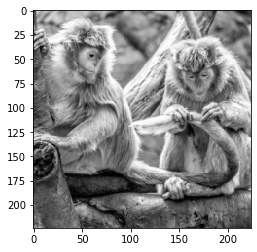

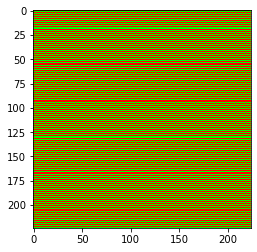

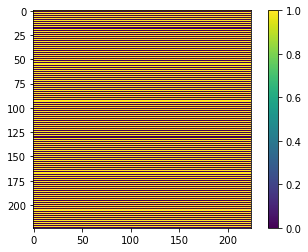

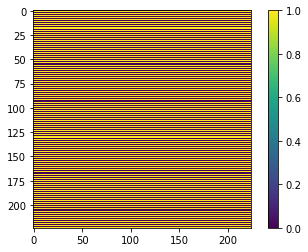

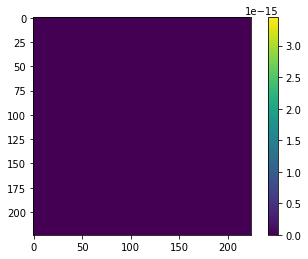

<Figure size 432x288 with 0 Axes>

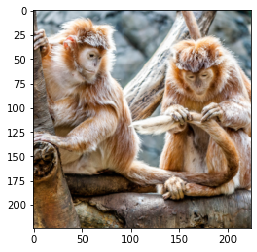

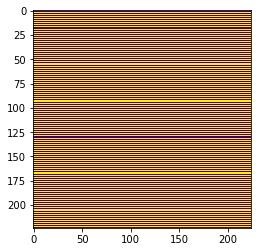

In [25]:
cpuModel = model.cpu()
out = model.generate(ex[1])
plt.figure()
plt.imshow(TenToPic(ex[1][0,:,:,:]))
plt.figure()
plt.imshow(TenToPic((out[0,:,:,:])))
plt.figure()
plt.imshow(out.detach().numpy()[0,0,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,1,:,:])
plt.colorbar()
plt.figure()
plt.imshow(out.detach().numpy()[0,2,:,:])
plt.colorbar()
plt.figure()
model.cuda()
temp = 1
plt.figure()
plt.imshow(TenToPic(ex[0][0,:,:,:]))
import pytorch_ssim
print("-----------")
#print(pytorch_ssim.ssim(out[:,:,:,:], ex[0][:,:,:,:]))
#print(pytorch_ssim.ssim(ex[0][:,:,:,:], ex[0][:,:,:,:]))

diff = out[0,0,:,:] - out[0,1,:,:]
plt.figure()
plt.imshow(diff[:,:].detach().numpy())